In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from linearmodels import PanelOLS
import datetime
from scipy.stats import f_oneway
import statsmodels.api as sm

# Data Cleaning
### Tables

In [2]:
muni = pd.read_stata('mexico_muni_jebo.dta')
muni.head()

,muni_code,state,municipality,year,month,temp_pop,precip_pop,id,rural,agriculture,...,temp_ac,progresa_per_capita,c_progresa_per_capita,temp_progresa,growing_season,temp_growing_season,state_id,sm,sy,temp_bin_pop_28_Inf
0,1001,Aguascalientes,Aguascalientes,2001.0,4.0,23.817400,0.113894,1.0,0.098599,0.058801,...,-1.352743,0.002714,-0.002086,-0.009950,1.0,4.769073,1.0,4.0,12.0,0.0
1,1001,Aguascalientes,Aguascalientes,1998.0,4.0,22.207600,0.000000,1.0,0.098599,0.058801,...,-0.896125,0.000000,-0.004800,-0.015165,1.0,3.159273,1.0,4.0,9.0,0.0
2,1001,Aguascalientes,Aguascalientes,2001.0,11.0,16.335100,0.038703,1.0,0.098599,0.058801,...,0.769604,0.004456,-0.000344,0.000932,0.0,0.000000,1.0,11.0,12.0,0.0
3,1001,Aguascalientes,Aguascalientes,2000.0,2.0,17.702499,0.002461,1.0,0.098599,0.058801,...,0.381742,0.002706,-0.002094,0.002818,0.0,0.000000,1.0,2.0,11.0,0.0
4,1001,Aguascalientes,Aguascalientes,2001.0,7.0,21.856300,1.110245,1.0,0.098599,0.058801,...,-0.796479,0.001304,-0.003496,-0.009817,1.0,2.807974,1.0,7.0,12.0,0.0


In [3]:
# Add a date column to support datetime data type
muni['day'] = 1
muni['date'] = pd.to_datetime(dict(year=muni.year, month=muni.month, day=muni.day))
# Convert Year and Month to Integers
muni['year'] = muni['year'].astype('int')
muni['month'] = muni['month'].astype('int')

In [4]:
state = pd.read_stata("mexico_state_jebo.dta")
state.head()

C:\Users\blahb\anaconda3\lib\site-packages\pandas\io\stata.py:1457: UnicodeWarning: 
One or more strings in the dta file could not be decoded using utf-8, and
so the fallback encoding of latin-1 is being used.  This can happen when a file
has been incorrectly encoded by Stata or some other software. You should verify
the string values returned are correct.
  warnings.warn(msg, UnicodeWarning)


,id,year,state,month,temperature,homsegob_rate,kid_rate,ext_rate,car_rate,precipitation
0,1804.0,1990.0,Aguascalientes,1.0,15.166670,NaN,NaN,NaN,NaN,0.007000
1,1804.0,1990.0,Aguascalientes,2.0,14.666670,NaN,NaN,NaN,NaN,0.018933
2,1804.0,1990.0,Aguascalientes,3.0,17.866671,NaN,NaN,NaN,NaN,0.002833
3,1804.0,1990.0,Aguascalientes,4.0,19.833330,NaN,NaN,NaN,NaN,0.001133
4,1804.0,1990.0,Aguascalientes,5.0,24.600000,NaN,NaN,NaN,NaN,0.037333


In [5]:
# Add a date column to support datetime data type
state['day'] = 1
state['date'] = pd.to_datetime(dict(year=state.year, month=state.month, day=state.day))
# Convert Year and Month to Integers
state['year'] = state['year'].astype('int')
state['month'] = state['month'].astype('int')

## Figure 2: Time Series in Violence

In [6]:
# Aggregate the Homicide Rate by date and t column weighting it to the population
fig2_df = muni.groupby(['t', 'date']).agg({'hom_rate': lambda x: (x * muni['popw']).mean() / muni['popw'].mean()}).reset_index()
fig2_df.head()

,t,date,hom_rate
0,1.0,1990-01-01,1.579638
1,2.0,1990-02-01,1.369551
2,3.0,1990-03-01,1.520228
3,4.0,1990-04-01,1.353619
4,5.0,1990-05-01,1.453345


[Text(7305.0, 0, '1990-01-01'),
 Text(13483.0, 0, '2006-12-01'),
 Text(14944.0, 0, '2010-12-01')]

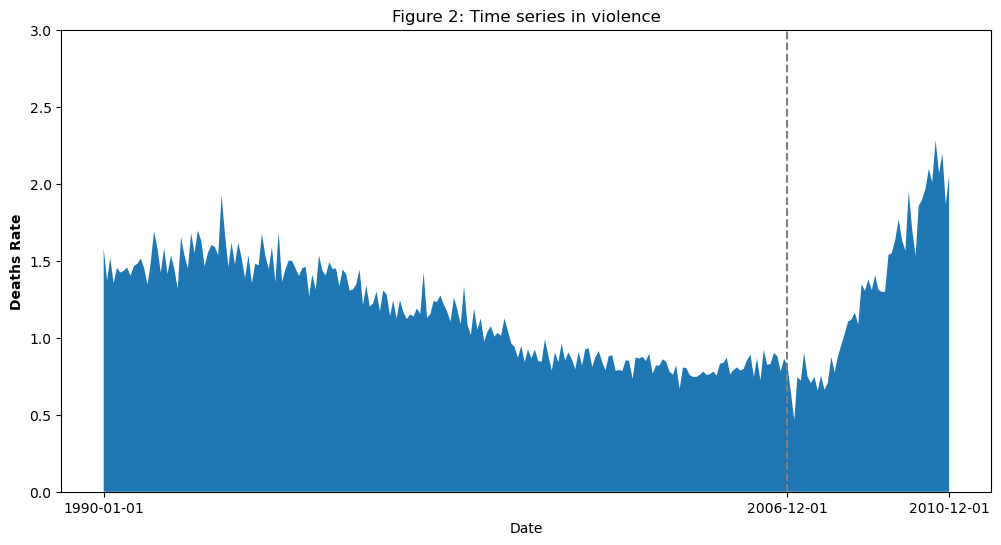

In [7]:
# Create the plot
fig, ax = plt.subplots(figsize = (12,6))

# Plot ranges and points
plt.stackplot(fig2_df['date'], fig2_df['hom_rate'])
plt.axvline(x = datetime.date(2006, 12, 1), linestyle = "--", color = 'gray')

# Styling
plt.xlabel('Date')
plt.ylabel('Deaths Rate', fontweight='bold')
plt.title('Figure 2: Time series in violence')
plt.ylim(0, 3)
ticks = fig2_df['date'].iloc[[0, 203,251]]
labels = [ i.strftime("%Y-%m-%d") for i in ticks ]
ax.set_xticks(ticks)
ax.set_xticklabels(labels)

## Figure 3: Temperature and violence in Mexico

In [8]:
# Bins for the temperature
t_bins = ['temp_bin_pop_0_9', 'temp_bin_pop_10_12', 'temp_bin_pop_13_15', 'temp_bin_pop_16_18', 'temp_bin_pop_19_21', 'temp_bin_pop_22_24', 'temp_bin_pop_25_27', 'temp_bin_pop_28_30', 'temp_bin_pop_31_Inf']

# More Table Data cleaning: Filter for years and drop Nan rows
fig_3 = muni[muni['year'] < 2007].dropna(subset = ['hom_rate', 'precip_pop'] + t_bins)

# Set the Index for the Entity Effects and Time Effects
fig_3 = fig_3.set_index(['muni_code', 'date'])
fig_3 = fig_3[['state', 'hom_rate', 'temp_pop','precip_pop', 'popw'] + t_bins]
fig_3.head()

state  hom_rate   temp_pop  precip_pop  \
muni_code date                                                          
1001      2001-04-01  Aguascalientes  0.301511  23.817400    0.113894   
          1998-04-01  Aguascalientes  0.642868  22.207600    0.000000   
          2001-11-01  Aguascalientes  0.297347  16.335100    0.038703   
          2000-02-01  Aguascalientes  0.000000  17.702499    0.002461   
          2001-07-01  Aguascalientes  0.149856  21.856300    1.110245   

                             popw  temp_bin_pop_0_9  temp_bin_pop_10_12  \
muni_code date                                                            
1001      2001-04-01  655030.9375               0.0             0.00000   
          1998-04-01  655030.9375               0.0             0.00000   
          2001-11-01  655030.9375               0.0             3.57944   
          2000-02-01  655030.9375               0.0             4.59084   
          2001-07-01  655030.9375               0.0             0.00000   

                      temp_bin_pop_13_15  temp_bin_pop_16_18  \
muni_code date                                                 
1001      2001-04-01              0.0000             3.18184   
          1998-04-01              0.0000             7.76124   
          2001-11-01             23.4091             3.01140   
          2000-02-01              8.7955            14.81830   
          2001-07-01              0.0000             5.56810   

                      temp_bin_pop_19_21  temp_bin_pop_22_24  \
muni_code date                                                 
1001      2001-04-01           14.784100           12.034201   
          1998-04-01           19.227299            3.011400   
          2001-11-01            0.000000            0.000000   
          2000-02-01            0.000000            0.000000   
          2001-07-01           24.829700            0.602280   

                      temp_bin_pop_25_27  temp_bin_pop_28_30  \
muni_code date                                                 
1001      2001-04-01                 0.0                 0.0   
          1998-04-01                 0.0                 0.0   
          2001-11-01                 0.0                 0.0   
          2000-02-01                 0.0                 0.0   
          2001-07-01                 0.0                 0.0   

                      temp_bin_pop_31_Inf  
muni_code date                             
1001      2001-04-01                  0.0  
          1998-04-01                  0.0  
          2001-11-01                  0.0  
          2000-02-01                  0.0  
          2001-07-01                  0.0

In [9]:
# Regressions with Time and Municipality Fixed Effects that are weighted population and clustered by state
fig3_mod = PanelOLS.from_formula('hom_rate ~ ' + ' + '.join(t_bins) + '+ precip_pop + EntityEffects + TimeEffects', data=fig_3, weights= fig_3['popw'])
fig3_results = fig3_mod.fit(cov_type='clustered', clusters = fig_3['state'])
fig3_coef = fig3_results.params
# 95% confidence level
fig3_ci = fig3_results.conf_int(level =  0.95)

fig3_result_df = pd.DataFrame({'coefficient': fig3_coef, 'CI_lower': fig3_ci['lower'], 'CI_upper': fig3_ci['upper']}).iloc[:-1, :]
fig3_result_df

,coefficient,CI_lower,CI_upper
temp_bin_pop_0_9,-0.002133,-0.018948,0.014681
temp_bin_pop_10_12,0.007094,-0.012527,0.026716
temp_bin_pop_13_15,0.005532,-0.008829,0.019894
temp_bin_pop_16_18,0.007021,-0.007913,0.021954
temp_bin_pop_19_21,0.007710,-0.007377,0.022796
temp_bin_pop_22_24,0.008335,-0.006913,0.023583
temp_bin_pop_25_27,0.011026,-0.004287,0.026338
temp_bin_pop_28_30,0.012324,-0.002477,0.027124
temp_bin_pop_31_Inf,0.014794,-0.001063,0.030650


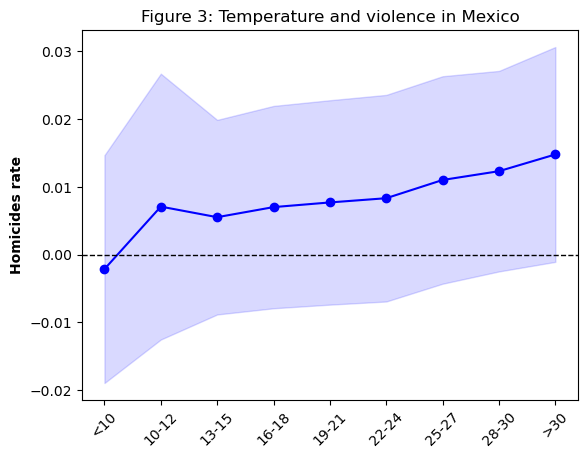

In [10]:
# Create the plot
fig, ax = plt.subplots()

# Plot ranges and points
ax.plot(fig3_result_df.index, fig3_result_df['coefficient'], '-o', color='blue')
ax.fill_between(fig3_result_df.index, fig3_result_df['CI_lower'], fig3_result_df['CI_upper'], color='b', alpha=.15)

# Styling
ax.set_title('Figure 3: Temperature and violence in Mexico')
ax.axhline(0, color='black', linewidth=1, linestyle='dashed')
ax.set_xticks(fig3_result_df.index)
ax.set_xticklabels(["<10", "10-12", "13-15", "16-18", "19-21", "22-24", "25-27", "28-30", ">30"], rotation=45)
ax.set_ylabel('Homicides rate', fontweight='bold')
ax.set_xlabel('')

# Show the plot
plt.show()

## Figure 5: Temperature and suicides

In [11]:
# More Table Data cleaning: Filter for years and drop Nan rows with same temperature bins as before
fig_5_df = muni[muni['year'] < 2007].dropna(subset = ['sui_rate', 'precip_pop'] + t_bins)

# Clustered around state, and have fixed effects for (muni_code, year, month)
fig_5_df = fig_5_df.set_index(['muni_code', 'date'])
fig_5_df = fig_5_df[['state', 'sui_rate', 'precip_pop', 'popw'] + t_bins]
fig_5_df.head()

state  sui_rate  precip_pop         popw  \
muni_code date                                                            
1001      2001-04-01  Aguascalientes  0.150756    0.113894  655030.9375   
          1998-04-01  Aguascalientes  0.160717    0.000000  655030.9375   
          2001-11-01  Aguascalientes  0.446021    0.038703  655030.9375   
          2000-02-01  Aguascalientes  0.620399    0.002461  655030.9375   
          2001-07-01  Aguascalientes  0.449569    1.110245  655030.9375   

                      temp_bin_pop_0_9  temp_bin_pop_10_12  \
muni_code date                                               
1001      2001-04-01               0.0             0.00000   
          1998-04-01               0.0             0.00000   
          2001-11-01               0.0             3.57944   
          2000-02-01               0.0             4.59084   
          2001-07-01               0.0             0.00000   

                      temp_bin_pop_13_15  temp_bin_pop_16_18  \
muni_code date                                                 
1001      2001-04-01              0.0000             3.18184   
          1998-04-01              0.0000             7.76124   
          2001-11-01             23.4091             3.01140   
          2000-02-01              8.7955            14.81830   
          2001-07-01              0.0000             5.56810   

                      temp_bin_pop_19_21  temp_bin_pop_22_24  \
muni_code date                                                 
1001      2001-04-01           14.784100           12.034201   
          1998-04-01           19.227299            3.011400   
          2001-11-01            0.000000            0.000000   
          2000-02-01            0.000000            0.000000   
          2001-07-01           24.829700            0.602280   

                      temp_bin_pop_25_27  temp_bin_pop_28_30  \
muni_code date                                                 
1001      2001-04-01                 0.0                 0.0   
          1998-04-01                 0.0                 0.0   
          2001-11-01                 0.0                 0.0   
          2000-02-01                 0.0                 0.0   
          2001-07-01                 0.0                 0.0   

                      temp_bin_pop_31_Inf  
muni_code date                             
1001      2001-04-01                  0.0  
          1998-04-01                  0.0  
          2001-11-01                  0.0  
          2000-02-01                  0.0  
          2001-07-01                  0.0

In [12]:
# Regressions with Time and Municipality Fixed Effects that are weighted population and clustered by state
fig5_mod = PanelOLS.from_formula('sui_rate ~ ' + ' + '.join(t_bins) + '+ precip_pop + EntityEffects + TimeEffects', data=fig_5_df, weights= fig_5_df['popw'])
fig5_results = fig5_mod.fit(cov_type='clustered', clusters = fig_5_df['state'])
fig5_coef = fig5_results.params
# 95% confidence level
fig5_ci = fig5_results.conf_int(level =  0.95)

fig5_result_df = pd.DataFrame({'coefficient': fig5_coef, 'CI_lower': fig5_ci['lower'], 'CI_upper': fig5_ci['upper']}).iloc[:-1, :]
fig5_result_df

,coefficient,CI_lower,CI_upper
temp_bin_pop_0_9,-0.001114,-0.005392,0.003164
temp_bin_pop_10_12,0.001647,-0.001652,0.004946
temp_bin_pop_13_15,0.001935,-0.001005,0.004874
temp_bin_pop_16_18,0.002260,-0.000739,0.005258
temp_bin_pop_19_21,0.003365,0.000266,0.006464
temp_bin_pop_22_24,0.003625,0.000666,0.006584
temp_bin_pop_25_27,0.004514,0.001389,0.007640
temp_bin_pop_28_30,0.005622,0.002486,0.008759
temp_bin_pop_31_Inf,0.005633,0.001465,0.009801


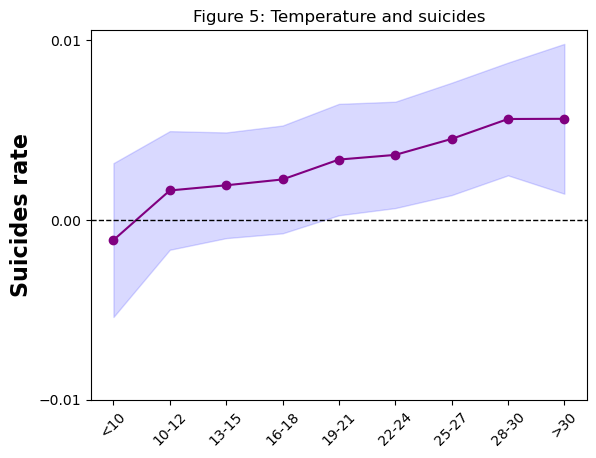

In [13]:
# Create the plot
fig, ax = plt.subplots()

# Plot ranges and points
ax.plot(fig5_result_df.index, fig5_result_df['coefficient'], '-o', color='purple')
ax.fill_between(fig5_result_df.index, fig5_result_df['CI_lower'], fig5_result_df['CI_upper'], color='b', alpha=.15)

# Styling
ax.set_title('Figure 5: Temperature and suicides')
ax.axhline(0, color='black', linewidth=1, linestyle='dashed')
ax.set_xticks(fig5_result_df.index)
ax.set_xticklabels(["<10", "10-12", "13-15", "16-18", "19-21", "22-24", "25-27", "28-30", ">30"], rotation=45)
ax.set_ylabel('Suicides rate', fontweight='bold', fontsize = 16)
ax.set_xlabel('')
ax.set_yticks([-0.01, 0.00, 0.01])

# Show the plot
plt.show()

The data is different from what is being replicated (Width of 2 for temp_pop bins in the data vs Width of 3 bins shown in the paper)

## Figure 6 : Temporal distribution of estimates

### Homicides Rate

In [14]:
fig6_df = muni.copy()
for i in range(1, 7):
    fig6_df[f'L{i}_temp_pop'] = muni['temp_pop'].shift(-i)
    fig6_df[f'F{i}_temp_pop'] = muni['temp_pop'].shift(i)
    fig6_df[f'L{i}_precip_pop'] = muni['precip_pop'].shift(-i)
    fig6_df[f'F{i}_precip_pop'] = muni['precip_pop'].shift(i)

fig6_df

,muni_code,state,municipality,year,month,temp_pop,precip_pop,id,rural,agriculture,...,L4_precip_pop,F4_precip_pop,L5_temp_pop,F5_temp_pop,L5_precip_pop,F5_precip_pop,L6_temp_pop,F6_temp_pop,L6_precip_pop,F6_precip_pop
0,1001,Aguascalientes,Aguascalientes,2001,4,23.817400,0.113894,1.0,0.098599,0.058801,...,1.110245,NaN,25.427000,NaN,0.696712,NaN,24.609200,NaN,0.276077,NaN
1,1001,Aguascalientes,Aguascalientes,1998,4,22.207600,0.000000,1.0,0.098599,0.058801,...,0.696712,NaN,24.609200,NaN,0.276077,NaN,18.081400,NaN,0.224986,NaN
2,1001,Aguascalientes,Aguascalientes,2001,11,16.335100,0.038703,1.0,0.098599,0.058801,...,0.276077,NaN,18.081400,NaN,0.224986,NaN,17.777901,NaN,0.003232,NaN
3,1001,Aguascalientes,Aguascalientes,2000,2,17.702499,0.002461,1.0,0.098599,0.058801,...,0.224986,NaN,17.777901,NaN,0.003232,NaN,15.954700,NaN,0.044783,NaN
4,1001,Aguascalientes,Aguascalientes,2001,7,21.856300,1.110245,1.0,0.098599,0.058801,...,0.003232,0.113894,15.954700,NaN,0.044783,NaN,14.781200,NaN,0.066093,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
618907,32058,Zacatecas,Santa María de la Paz,1994,5,26.773199,0.082976,2439.0,NaN,NaN,...,0.262075,2.016423,NaN,19.999300,NaN,0.032483,NaN,20.299299,NaN,0.000000
618908,32058,Zacatecas,Santa María de la Paz,1994,10,23.050100,0.558740,2439.0,NaN,NaN,...,NaN,0.919619,NaN,24.312500,NaN,2.016423,NaN,19.999300,NaN,0.032483
618909,32058,Zacatecas,Santa María de la Paz,1997,11,19.530899,0.683117,2439.0,NaN,NaN,...,NaN,0.181287,NaN,23.688601,NaN,0.919619,NaN,24.312500,NaN,2.016423
618910,32058,Zacatecas,Santa María de la Paz,1994,11,20.543400,0.122095,2439.0,NaN,NaN,...,NaN,0.081205,NaN,20.621401,NaN,0.181287,NaN,23.688601,NaN,0.919619


In [15]:
temp_lags = ['L1_temp_pop', 'L2_temp_pop', 'L3_temp_pop', 'L4_temp_pop', 'L5_temp_pop', 'L6_temp_pop']
temp_leads = ['F1_temp_pop', 'F2_temp_pop', 'F3_temp_pop', 'F4_temp_pop', 'F5_temp_pop', 'F6_temp_pop']
precip_lags = ['L1_precip_pop', 'L2_precip_pop', 'L3_precip_pop', 'L4_precip_pop', 'L5_precip_pop', 'L6_precip_pop']
precip_leads = ['F1_precip_pop', 'F2_precip_pop', 'F3_precip_pop', 'F4_precip_pop', 'F5_precip_pop', 'F6_precip_pop']

fig_6_hom_df = fig6_df[muni['year'] <= 2006].dropna(subset = ['hom_rate', 'temp_pop', 'precip_pop'] + temp_lags + temp_leads + precip_lags + precip_leads)

# Clustered around state, and have fixed effects for (muni_code, year, month)
fig_6_hom_df = fig_6_hom_df.set_index(['muni_code', 'date'])
fig_6_hom_df = fig_6_hom_df[['state', 'hom_rate', 'temp_pop', 'precip_pop', 'popw', 'year', 'month'] + temp_lags + temp_leads + precip_lags + precip_leads]
fig_6_hom_df

state   hom_rate   temp_pop  precip_pop  \
muni_code date                                                           
1001      1995-05-01  Aguascalientes   0.511190  24.609200    0.276077   
          2004-03-01  Aguascalientes   0.000000  18.081400    0.224986   
          2001-02-01  Aguascalientes   0.000000  17.777901    0.003232   
          2004-11-01  Aguascalientes   0.138814  15.954700    0.044783   
          2000-12-01  Aguascalientes   0.000000  14.781200    0.066093   
...                              ...        ...        ...         ...   
32058     2006-11-01       Zacatecas   0.000000  18.696400    0.192440   
          2005-12-01       Zacatecas   0.000000  17.435801    0.000000   
          2005-03-01       Zacatecas  38.355366  19.163700    0.044328   
          2006-03-01       Zacatecas   0.000000  21.108900    0.002020   
          2005-06-01       Zacatecas   0.000000  26.785601    0.608296   

                             popw  year  month  L1_temp_pop  L2_temp_pop  \
muni_code date                                                             
1001      1995-05-01  655030.9375  1995      5    18.081400    17.777901   
          2004-03-01  655030.9375  2004      3    17.777901    15.954700   
          2001-02-01  655030.9375  2001      2    15.954700    14.781200   
          2004-11-01  655030.9375  2004     11    14.781200    20.348000   
          2000-12-01  655030.9375  2000     12    20.348000    20.284000   
...                           ...   ...    ...          ...          ...   
32058     2006-11-01    2711.0000  2006     11    18.336500    18.858900   
          2005-12-01    2711.0000  2005     12    21.139700    24.843300   
          2005-03-01    2711.0000  2005      3    25.088499    20.758900   
          2006-03-01    2711.0000  2006      3    26.785601    23.596201   
          2005-06-01    2711.0000  2005      6    23.596201    23.631800   

                      L3_temp_pop  ...  L3_precip_pop  L4_precip_pop  \
muni_code date                     ...                                 
1001      1995-05-01    15.954700  ...       0.044783       0.066093   
          2004-03-01    14.781200  ...       0.066093       1.055530   
          2001-02-01    20.348000  ...       1.055530       0.220284   
          2004-11-01    20.284000  ...       0.220284       1.415172   
          2000-12-01    20.912001  ...       1.415172       0.394909   
...                           ...  ...            ...            ...   
32058     2006-11-01    17.495399  ...       0.042749       0.686915   
          2005-12-01    17.578100  ...       0.072946       2.990277   
          2005-03-01    20.429001  ...       0.248289       0.032898   
          2006-03-01    23.631800  ...       1.272054       0.046924   
          2005-06-01    17.292601  ...       0.046924       0.000000   

                      L5_precip_pop  L6_precip_pop  F1_precip_pop  \
muni_code date                                                      
1001      1995-05-01       1.055530       0.220284       0.696712   
          2004-03-01       0.220284       1.415172       0.276077   
          2001-02-01       1.415172       0.394909       0.224986   
          2004-11-01       0.394909       0.393988       0.003232   
          2000-12-01       0.393988       0.170750       0.044783   
...                             ...            ...            ...   
32058     2006-11-01       0.000404       0.003232       0.365766   
          2005-12-01       0.000404       0.758875       1.676501   
          2005-03-01       0.108997       0.003232       0.283470   
          2006-03-01       0.000000       2.048760       0.129901   
          2005-06-01       2.048760       0.370043       0.002020   

                      F2_precip_pop  F3_precip_pop  F4_precip_pop  \
muni_code date                                                      
1001      1995-05-01       1.110245       0.002461       0.038703   
          2004-03-01       0.696712  

In [16]:
mod_fig_6_hom = PanelOLS.from_formula('hom_rate ~ temp_pop + ' + ' + '.join(temp_lags) + ' + ' + ' + '.join(temp_leads) + ' + precip_pop' + ' + ' + ' + '.join(precip_lags) + ' + ' + ' + '.join(precip_leads) + ' + TimeEffects + EntityEffects', data=fig_6_hom_df, weights= fig_6_hom_df['popw'])
fig6_results = mod_fig_6_hom.fit(cov_type='clustered', clusters = fig_6_hom_df['state'])

fig6_coef = fig6_results.params
fig6_ci = fig6_results.conf_int() # 95% confidence level

result_df_fig_6_hom = pd.DataFrame({'coefficient': fig6_coef, 'CI_lower': fig6_ci['lower'], 'CI_upper': fig6_ci['upper']})

# Add the estimate together for the lags and leads for the plots
result_df_fig_6_hom = result_df_fig_6_hom.iloc[:-13, :].reindex(temp_lags[::-1] + ['temp_pop'] + temp_leads)
result_df_fig_6_hom

,coefficient,CI_lower,CI_upper
L6_temp_pop,-0.000799,-0.003210,0.001613
L5_temp_pop,-0.000194,-0.002995,0.002607
L4_temp_pop,-0.003508,-0.005920,-0.001097
L3_temp_pop,-0.001269,-0.003478,0.000939
L2_temp_pop,-0.000978,-0.004269,0.002313
L1_temp_pop,-0.002053,-0.004532,0.000425
temp_pop,0.015693,0.008152,0.023233
F1_temp_pop,-0.000493,-0.002661,0.001675
F2_temp_pop,0.001945,-0.000697,0.004587
F3_temp_pop,0.002411,-0.000944,0.005766


### Suicides Rate

In [17]:
fig_6_sui_df = fig6_df[fig6_df['year'] <= 2006].dropna(subset = ['sui_rate', 'temp_pop', 'precip_pop'] + temp_lags + temp_leads + precip_lags + precip_leads)

fig_6_sui_df = fig_6_sui_df.set_index(['muni_code', 'date'])
fig_6_sui_df = fig_6_sui_df[['state', 'sui_rate', 'temp_pop', 'precip_pop', 'popw', 'year', 'month'] + temp_lags + temp_leads + precip_lags + precip_leads]
fig_6_sui_df

state  sui_rate   temp_pop  precip_pop  \
muni_code date                                                          
1001      1995-05-01  Aguascalientes  0.340793  24.609200    0.276077   
          2004-03-01  Aguascalientes  0.422671  18.081400    0.224986   
          2001-02-01  Aguascalientes  0.151361  17.777901    0.003232   
          2004-11-01  Aguascalientes  0.694070  15.954700    0.044783   
          2000-12-01  Aguascalientes  0.151972  14.781200    0.066093   
...                              ...       ...        ...         ...   
32058     2006-11-01       Zacatecas  0.000000  18.696400    0.192440   
          2005-12-01       Zacatecas  0.000000  17.435801    0.000000   
          2005-03-01       Zacatecas  0.000000  19.163700    0.044328   
          2006-03-01       Zacatecas  0.000000  21.108900    0.002020   
          2005-06-01       Zacatecas  0.000000  26.785601    0.608296   

                             popw  year  month  L1_temp_pop  L2_temp_pop  \
muni_code date                                                             
1001      1995-05-01  655030.9375  1995      5    18.081400    17.777901   
          2004-03-01  655030.9375  2004      3    17.777901    15.954700   
          2001-02-01  655030.9375  2001      2    15.954700    14.781200   
          2004-11-01  655030.9375  2004     11    14.781200    20.348000   
          2000-12-01  655030.9375  2000     12    20.348000    20.284000   
...                           ...   ...    ...          ...          ...   
32058     2006-11-01    2711.0000  2006     11    18.336500    18.858900   
          2005-12-01    2711.0000  2005     12    21.139700    24.843300   
          2005-03-01    2711.0000  2005      3    25.088499    20.758900   
          2006-03-01    2711.0000  2006      3    26.785601    23.596201   
          2005-06-01    2711.0000  2005      6    23.596201    23.631800   

                      L3_temp_pop  ...  L3_precip_pop  L4_precip_pop  \
muni_code date                     ...                                 
1001      1995-05-01    15.954700  ...       0.044783       0.066093   
          2004-03-01    14.781200  ...       0.066093       1.055530   
          2001-02-01    20.348000  ...       1.055530       0.220284   
          2004-11-01    20.284000  ...       0.220284       1.415172   
          2000-12-01    20.912001  ...       1.415172       0.394909   
...                           ...  ...            ...            ...   
32058     2006-11-01    17.495399  ...       0.042749       0.686915   
          2005-12-01    17.578100  ...       0.072946       2.990277   
          2005-03-01    20.429001  ...       0.248289       0.032898   
          2006-03-01    23.631800  ...       1.272054       0.046924   
          2005-06-01    17.292601  ...       0.046924       0.000000   

                      L5_precip_pop  L6_precip_pop  F1_precip_pop  \
muni_code date                                                      
1001      1995-05-01       1.055530       0.220284       0.696712   
          2004-03-01       0.220284       1.415172       0.276077   
          2001-02-01       1.415172       0.394909       0.224986   
          2004-11-01       0.394909       0.393988       0.003232   
          2000-12-01       0.393988       0.170750       0.044783   
...                             ...            ...            ...   
32058     2006-11-01       0.000404       0.003232       0.365766   
          2005-12-01       0.000404       0.758875       1.676501   
          2005-03-01       0.108997       0.003232       0.283470   
          2006-03-01       0.000000       2.048760       0.129901   
          2005-06-01       2.048760       0.370043       0.002020   

                      F2_precip_pop  F3_precip_pop  F4_precip_pop  \
muni_code date                                                      
1001      1995-05-01       1.110245       0.002461       0.038703   
          2004-03-01       0.696712       1.110245

In [18]:
mod_fig_6_sui = PanelOLS.from_formula('sui_rate ~ temp_pop + ' + ' + '.join(temp_lags) + ' + ' + ' + '.join(temp_leads) + ' + precip_pop' + ' + ' + ' + '.join(precip_lags) + ' + ' + ' + '.join(precip_leads) + ' + TimeEffects + EntityEffects', data=fig_6_sui_df, weights= fig_6_sui_df['popw'])
results_sui = mod_fig_6_sui.fit(cov_type='clustered', clusters = fig_6_sui_df['state'])

coefficients_sui = results_sui.params
confidence_interval_sui = results_sui.conf_int() # 95% confidence level

result_df_fig_6_sui = pd.DataFrame({'coefficient': coefficients_sui, 'CI_lower': confidence_interval_sui['lower'], 'CI_upper': confidence_interval_sui['upper']})

# Add the estimate together for the lags and leads for the plots
result_df_fig_6_sui = result_df_fig_6_sui.iloc[:-13, :].reindex(temp_lags[::-1] + ['temp_pop'] + temp_leads)
result_df_fig_6_sui

,coefficient,CI_lower,CI_upper
L6_temp_pop,-0.000551,-0.001558,0.000455
L5_temp_pop,-0.000051,-0.000862,0.000761
L4_temp_pop,-0.000393,-0.000997,0.000211
L3_temp_pop,-0.000195,-0.000809,0.000419
L2_temp_pop,-0.000118,-0.001220,0.000984
L1_temp_pop,-0.000003,-0.001066,0.001060
temp_pop,0.007186,0.005241,0.009130
F1_temp_pop,0.000063,-0.000788,0.000913
F2_temp_pop,-0.000950,-0.002253,0.000353
F3_temp_pop,0.000137,-0.001282,0.001557


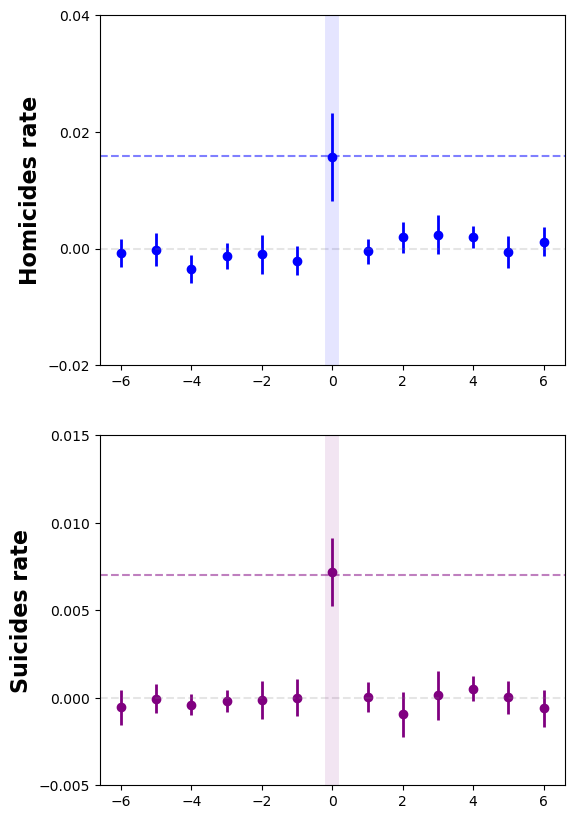

In [19]:
x = np.arange(-6, 7)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 10))

ax1.scatter(x, result_df_fig_6_hom['coefficient'], color='blue')
ax1.vlines(x, result_df_fig_6_hom['CI_lower'], result_df_fig_6_hom['CI_upper'], color='blue', lw=2)
ax1.axhline(0, linestyle='--', color='gray', alpha = 0.2)
ax1.axhline(0.0158, linestyle='--', color='blue', alpha = 0.5)
ax1.axvline(0, linewidth = 10, color='blue', alpha = 0.1)
ax1.set_xlabel('')
ax1.set_ylabel('Homicides rate', fontweight='bold', fontsize= 16)
ax1.set_yticks([-.02, 0, .02, .04])

ax2.scatter(x, result_df_fig_6_sui['coefficient'], color='purple')
ax2.vlines(x, result_df_fig_6_sui['CI_lower'], result_df_fig_6_sui['CI_upper'], color='purple', lw=2)
ax2.axhline(0, linestyle='--', color='gray', alpha = 0.2)
ax2.axhline(0.0070, linestyle='--', color='purple', alpha = 0.5)
ax2.axvline(0, linewidth = 10, color='purple', alpha = 0.1)
ax2.set_xlabel('')
ax2.set_ylabel('Suicides rate', fontweight='bold', fontsize= 16)
ax2.set_yticks([-.005, 0, .005, .01, .015])

plt.show()

## Table 1: Descriptive Statistics

In [20]:
vars = ['hom_rate', 'sui_rate', 'population', 'temp_pop', 'precip_pop']
tbl1_1 = muni[muni['year'] < 2007][vars].describe().loc[['mean', 'std', 'count']].applymap(lambda x: f"{x:9.2f}")
tbl1_1

,hom_rate,sui_rate,population,temp_pop,precip_pop
mean,0.98,0.21,39057.12,20.10,0.93
std,5.23,1.92,116901.42,5.00,1.12
count,494724.00,494724.00,494724.00,500208.00,500208.00


In [21]:
vars = ['hom_rate', 'sui_rate', 'population', 'temp_pop', 'precip_pop']
tbl1_2 = muni[muni['year'] >= 2007][vars].describe().loc[['mean', 'std', 'count']].applymap(lambda x: f"{x:9.2f}")
tbl1_2

,hom_rate,sui_rate,population,temp_pop,precip_pop
mean,0.83,0.26,44584.62,20.05,0.81
std,4.13,2.21,130760.44,5.09,1.07
count,117650.00,117650.00,117650.00,117696.00,117696.00


In [22]:
tbl1_df_filtered = muni[muni['year'] < 2007]
tbl1_df = tbl1_df_filtered.groupby('muni_code')['hom_rate'].apply(list)
x = f_oneway(tbl1_df[1001],tbl1_df[1002],tbl1_df[1003],tbl1_df[1004],tbl1_df[1005],tbl1_df[1006],tbl1_df[1007],tbl1_df[1008],tbl1_df[1009], tbl1_df[1011])
print(x)

F_onewayResult(statistic=nan, pvalue=nan)


Cannot run f_oneway for data with more than 9 groups

## Table 2: Temperature and Violence in Mexico

In [23]:
tbl2_df = muni[muni['year'] < 2007].dropna().set_index(['muni_code', 'date'])[['temp_pop', 'state', 'hom_rate', 'precip_pop', 'popw']]
tbl2_df.head()

temp_pop           state  hom_rate  precip_pop  \
muni_code date                                                          
1001      2001-04-01  23.817400  Aguascalientes  0.301511    0.113894   
          1998-04-01  22.207600  Aguascalientes  0.642868    0.000000   
          2001-11-01  16.335100  Aguascalientes  0.297347    0.038703   
          2000-02-01  17.702499  Aguascalientes  0.000000    0.002461   
          2001-07-01  21.856300  Aguascalientes  0.149856    1.110245   

                             popw  
muni_code date                     
1001      2001-04-01  655030.9375  
          1998-04-01  655030.9375  
          2001-11-01  655030.9375  
          2000-02-01  655030.9375  
          2001-07-01  655030.9375

In [24]:
# Column 5
col5_model = PanelOLS.from_formula('hom_rate ~ temp_pop + precip_pop + EntityEffects + TimeEffects', data=tbl2_df, weights = tbl2_df['popw'])
col5_results = col5_model.fit(cov_type='clustered', clusters = tbl2_df['state'])

print(col5_results)

                          PanelOLS Estimation Summary                           
Dep. Variable:               hom_rate   R-squared:                        0.0005
Estimator:                   PanelOLS   R-squared (Between):              0.1645
No. Observations:              119136   R-squared (Within):              -0.0001
Date:                Fri, Apr 26 2024   R-squared (Overall):              0.1004
Time:                        15:10:14   Log-likelihood                -2.159e+05
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      27.802
Entities:                         584   P-value                           0.0000
Avg Obs:                       204.00   Distribution:                F(2,118347)
Min Obs:                       204.00                                           
Max Obs:                       204.00   F-statistic (robust):             10.238
                            

### Table 3: Temperature and Economically Motivated Crimes

In [25]:
tbl3_df = state[state['year'] >= 2007]
tbl3_df['month'] = pd.Categorical(tbl3_df['month'])
tbl3_df['year'] = pd.Categorical(tbl3_df['year'])
tbl3_df

C:\Users\blahb\AppData\Local\Temp\ipykernel_16636\686763787.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tbl3_df['month'] = pd.Categorical(tbl3_df['month'])
C:\Users\blahb\AppData\Local\Temp\ipykernel_16636\686763787.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tbl3_df['year'] = pd.Categorical(tbl3_df['year'])


,id,year,state,month,temperature,homsegob_rate,kid_rate,ext_rate,car_rate,precipitation,day,date
204,1804.0,2007,Aguascalientes,1,13.600000,0.178575,0.000000,0.625011,5.267951,0.000000,1,2007-01-01
205,1804.0,2007,Aguascalientes,2,14.566670,0.535724,0.000000,0.178575,3.035769,0.009033,1,2007-02-01
206,1804.0,2007,Aguascalientes,3,18.100000,0.089287,0.178575,0.446437,2.857194,0.000367,1,2007-03-01
207,1804.0,2007,Aguascalientes,4,19.299999,0.178575,0.267862,0.178575,3.214343,0.000067,1,2007-04-01
208,1804.0,2007,Aguascalientes,5,22.066669,0.357149,0.267862,0.267862,2.589332,0.013700,1,2007-05-01
...,...,...,...,...,...,...,...,...,...,...,...,...
8059,1835.0,2010,Zacatecas,8,21.160000,0.402504,0.000000,0.067084,17.576014,0.053152,1,2010-08-01
8060,1835.0,2010,Zacatecas,9,19.936001,0.603756,0.000000,0.134168,22.875650,0.115984,1,2010-09-01
8061,1835.0,2010,Zacatecas,10,17.436001,0.805008,0.067084,0.067084,15.965997,0.009844,1,2010-10-01
8062,1835.0,2010,Zacatecas,11,14.444000,0.872092,0.268336,0.067084,16.234333,0.008048,1,2010-11-01


In [26]:
model_a = sm.OLS.from_formula('homsegob_rate ~ temperature + precipitation + C(month) + C(year) + C(id)', data=tbl3_df)
result_a = model_a.fit()

model_b = sm.OLS.from_formula('car_rate ~ temperature + precipitation + C(month) + C(year) + C(id)', data=tbl3_df)
result_b = model_b.fit()

model_c = sm.OLS.from_formula('ext_rate ~ temperature + precipitation + C(month) + C(year) + C(id)', data=tbl3_df)
result_c = model_c.fit()

model_d = sm.OLS.from_formula('kid_rate ~ temperature + precipitation + C(month) + C(year) + C(id)', data=tbl3_df)
result_d = model_d.fit()

In [27]:
print(result_a.summary())

                            OLS Regression Results                            
Dep. Variable:          homsegob_rate   R-squared:                       0.714
Model:                            OLS   Adj. R-squared:                  0.705
Method:                 Least Squares   F-statistic:                     78.99
Date:                Fri, 26 Apr 2024   Prob (F-statistic):               0.00
Time:                        15:10:14   Log-Likelihood:                -1876.4
No. Observations:                1535   AIC:                             3849.
Df Residuals:                    1487   BIC:                             4105.
Df Model:                          47                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -0.8281      0.224     

In [28]:
print(result_b.summary())

                            OLS Regression Results                            
Dep. Variable:               car_rate   R-squared:                       0.886
Model:                            OLS   Adj. R-squared:                  0.882
Method:                 Least Squares   F-statistic:                     245.2
Date:                Fri, 26 Apr 2024   Prob (F-statistic):               0.00
Time:                        15:10:14   Log-Likelihood:                -4821.7
No. Observations:                1535   AIC:                             9739.
Df Residuals:                    1487   BIC:                             9996.
Df Model:                          47                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           9.1116      1.523     

In [29]:
print(result_c.summary())

                            OLS Regression Results                            
Dep. Variable:               ext_rate   R-squared:                       0.603
Model:                            OLS   Adj. R-squared:                  0.590
Method:                 Least Squares   F-statistic:                     47.96
Date:                Fri, 26 Apr 2024   Prob (F-statistic):          1.45e-260
Time:                        15:10:14   Log-Likelihood:                -605.89
No. Observations:                1535   AIC:                             1308.
Df Residuals:                    1487   BIC:                             1564.
Df Model:                          47                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.2571      0.098     

In [30]:
print(result_d.summary())

                            OLS Regression Results                            
Dep. Variable:               kid_rate   R-squared:                       0.392
Model:                            OLS   Adj. R-squared:                  0.372
Method:                 Least Squares   F-statistic:                     20.34
Date:                Fri, 26 Apr 2024   Prob (F-statistic):          3.79e-127
Time:                        15:10:14   Log-Likelihood:                 1538.7
No. Observations:                1534   AIC:                            -2981.
Df Residuals:                    1486   BIC:                            -2725.
Df Model:                          47                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.0809      0.024     

### Table 4: Interaction with Economic Variables

In [31]:
#TABLE 4 COLUMN 5
table_4_inc_df = muni[muni['year'] <= 2006].dropna(subset = ['hom_rate', 'temp_pop', 'temp_income'])
table_4_inc_df = table_4_inc_df.set_index(['muni_code', 'date'])
table_4_inc_df = table_4_inc_df[['state', 'hom_rate', 'popw', 'temp_pop', 'precip_pop', 'temp_income']]
table_4_inc_df

state  hom_rate         popw   temp_pop  \
muni_code date                                                           
1001      2001-04-01  Aguascalientes  0.301511  655030.9375  23.817400   
          1998-04-01  Aguascalientes  0.642868  655030.9375  22.207600   
          2001-11-01  Aguascalientes  0.297347  655030.9375  16.335100   
          2000-02-01  Aguascalientes  0.000000  655030.9375  17.702499   
          2001-07-01  Aguascalientes  0.149856  655030.9375  21.856300   
...                              ...       ...          ...        ...   
32056     2003-05-01       Zacatecas  0.773258  124968.4375  21.100000   
          1993-03-01       Zacatecas  2.608534  124968.4375  13.100000   
          2003-07-01       Zacatecas  0.000000  124968.4375  16.400000   
          2005-12-01       Zacatecas  1.503913  124968.4375  11.900000   
          2004-11-01       Zacatecas  1.517868  124968.4375  13.100000   

                      precip_pop  temp_income  
muni_code date                                 
1001      2001-04-01    0.113894     2.531495  
          1998-04-01    0.000000     1.676989  
          2001-11-01    0.038703    -1.440221  
          2000-02-01    0.002461    -0.714385  
          2001-07-01    1.110245     1.490514  
...                          ...          ...  
32056     2003-05-01    1.465000     1.397331  
          1993-03-01    0.016000    -0.597725  
          2003-07-01    1.907000     0.225235  
          2005-12-01    0.031000    -0.896983  
          2004-11-01    0.029000    -0.597725  

[486132 rows x 6 columns]

In [32]:
mod_inc = PanelOLS.from_formula('hom_rate ~ temp_pop + precip_pop + temp_income + TimeEffects + EntityEffects', data=table_4_inc_df, weights= table_4_inc_df['popw'])

result_inc = mod_inc.fit(cov_type='clustered', clusters = table_4_inc_df['state'])

print(result_inc.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:               hom_rate   R-squared:                        0.0002
Estimator:                   PanelOLS   R-squared (Between):              0.1482
No. Observations:              486132   R-squared (Within):              -0.0001
Date:                Fri, Apr 26 2024   R-squared (Overall):              0.0669
Time:                        15:11:42   Log-likelihood                -1.034e+06
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      33.295
Entities:                        2383   P-value                           0.0000
Avg Obs:                       204.00   Distribution:                F(3,483543)
Min Obs:                       204.00                                           
Max Obs:                       204.00   F-statistic (robust):             7.6896
                            

In [33]:
#TABLE 4 COLUMN 6
table_4_gini_df = muni[muni['year'] <= 2006].dropna(subset = ['hom_rate', 'temp_pop', 'temp_gini'])
table_4_gini_df = table_4_gini_df.set_index(['muni_code', 'date'])
table_4_gini_df = table_4_gini_df[['state', 'hom_rate', 'popw', 'temp_pop', 'precip_pop', 'temp_gini']]
table_4_gini_df

state  hom_rate         popw   temp_pop  \
muni_code date                                                           
1001      2001-04-01  Aguascalientes  0.301511  655030.9375  23.817400   
          1998-04-01  Aguascalientes  0.642868  655030.9375  22.207600   
          2001-11-01  Aguascalientes  0.297347  655030.9375  16.335100   
          2000-02-01  Aguascalientes  0.000000  655030.9375  17.702499   
          2001-07-01  Aguascalientes  0.149856  655030.9375  21.856300   
...                              ...       ...          ...        ...   
32056     2003-05-01       Zacatecas  0.773258  124968.4375  21.100000   
          1993-03-01       Zacatecas  2.608534  124968.4375  13.100000   
          2003-07-01       Zacatecas  0.000000  124968.4375  16.400000   
          2005-12-01       Zacatecas  1.503913  124968.4375  11.900000   
          2004-11-01       Zacatecas  1.517868  124968.4375  13.100000   

                      precip_pop  temp_gini  
muni_code date                               
1001      2001-04-01    0.113894   2.167502  
          1998-04-01    0.000000   1.435862  
          2001-11-01    0.038703  -1.233138  
          2000-02-01    0.002461  -0.611667  
          2001-07-01    1.110245   1.276200  
...                          ...        ...  
32056     2003-05-01    1.465000  -0.385651  
          1993-03-01    0.016000   0.164967  
          2003-07-01    1.907000  -0.062163  
          2005-12-01    0.031000   0.247560  
          2004-11-01    0.029000   0.164967  

[482868 rows x 6 columns]

In [34]:
mod_gini = PanelOLS.from_formula('hom_rate ~ temp_pop + precip_pop + temp_gini + TimeEffects + EntityEffects', data=table_4_gini_df, weights= table_4_gini_df['popw'])

result_gini = mod_gini.fit(cov_type='clustered', clusters = table_4_gini_df['state'])

print(result_gini.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:               hom_rate   R-squared:                        0.0002
Estimator:                   PanelOLS   R-squared (Between):              0.1638
No. Observations:              482868   R-squared (Within):              -0.0001
Date:                Fri, Apr 26 2024   R-squared (Overall):              0.0741
Time:                        15:13:20   Log-likelihood                -1.026e+06
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      32.459
Entities:                        2367   P-value                           0.0000
Avg Obs:                       204.00   Distribution:                F(3,480295)
Min Obs:                       204.00                                           
Max Obs:                       204.00   F-statistic (robust):             6.7431
                            

In [35]:
#TABLE 4 COLUMN 7
table_4_ac_df = muni[(muni['year'] <= 2006) & (muni['ac_data'] == 1)].dropna(subset = ['hom_rate', 'temp_pop', 'temp_ac'])
table_4_ac_df = table_4_ac_df.set_index(['muni_code', 'date'])
table_4_ac_df = table_4_ac_df[['state', 'hom_rate', 'popw', 'temp_pop', 'precip_pop', 'temp_ac']]
table_4_ac_df

state  hom_rate         popw   temp_pop  \
muni_code date                                                           
1001      2001-04-01  Aguascalientes  0.301511  655030.9375  23.817400   
          1998-04-01  Aguascalientes  0.642868  655030.9375  22.207600   
          2001-11-01  Aguascalientes  0.297347  655030.9375  16.335100   
          2000-02-01  Aguascalientes  0.000000  655030.9375  17.702499   
          2001-07-01  Aguascalientes  0.149856  655030.9375  21.856300   
...                              ...       ...          ...        ...   
32056     2003-05-01       Zacatecas  0.773258  124968.4375  21.100000   
          1993-03-01       Zacatecas  2.608534  124968.4375  13.100000   
          2003-07-01       Zacatecas  0.000000  124968.4375  16.400000   
          2005-12-01       Zacatecas  1.503913  124968.4375  11.900000   
          2004-11-01       Zacatecas  1.517868  124968.4375  13.100000   

                      precip_pop   temp_ac  
muni_code date                              
1001      2001-04-01    0.113894 -1.352743  
          1998-04-01    0.000000 -0.896125  
          2001-11-01    0.038703  0.769604  
          2000-02-01    0.002461  0.381742  
          2001-07-01    1.110245 -0.796479  
...                          ...       ...  
32056     2003-05-01    1.465000 -2.459257  
          1993-03-01    0.016000  1.051976  
          2003-07-01    1.907000 -0.396407  
          2005-12-01    0.031000  1.578662  
          2004-11-01    0.029000  1.051976  

[121056 rows x 6 columns]

In [36]:
mod_ac = PanelOLS.from_formula('hom_rate ~ temp_pop + precip_pop + temp_ac + TimeEffects + EntityEffects', data=table_4_ac_df, weights= table_4_ac_df['popw'])

result_hom = mod_ac.fit(cov_type='clustered', clusters = table_4_ac_df['state'])

print(result_hom.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:               hom_rate   R-squared:                        0.0005
Estimator:                   PanelOLS   R-squared (Between):              0.2073
No. Observations:              121056   R-squared (Within):              -0.0003
Date:                Fri, Apr 26 2024   R-squared (Overall):              0.1263
Time:                        15:13:33   Log-likelihood                -2.193e+05
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      20.628
Entities:                         599   P-value                           0.0000
Avg Obs:                       202.10   Distribution:                F(3,120251)
Min Obs:                       24.000                                           
Max Obs:                       204.00   F-statistic (robust):             7.9397
                            

In [37]:
#TABLE 4 COLUMN 8
table_4_at_df = muni[muni['year'] <= 2006].dropna(subset = ['hom_rate', 'temp_pop', 'temp_avg_temp'])
table_4_at_df = table_4_at_df.set_index(['muni_code', 'date'])
table_4_at_df = table_4_at_df[['state', 'hom_rate', 'popw', 'temp_pop', 'precip_pop', 'temp_avg_temp']]
table_4_at_df

state   hom_rate         popw   temp_pop  \
muni_code date                                                            
1001      2001-04-01  Aguascalientes   0.301511  655030.9375  23.817400   
          1998-04-01  Aguascalientes   0.642868  655030.9375  22.207600   
          2001-11-01  Aguascalientes   0.297347  655030.9375  16.335100   
          2000-02-01  Aguascalientes   0.000000  655030.9375  17.702499   
          2001-07-01  Aguascalientes   0.149856  655030.9375  21.856300   
...                              ...        ...          ...        ...   
32058     2006-11-01       Zacatecas   0.000000    2711.0000  18.696400   
          2005-12-01       Zacatecas   0.000000    2711.0000  17.435801   
          2005-03-01       Zacatecas  38.355366    2711.0000  19.163700   
          2006-03-01       Zacatecas   0.000000    2711.0000  21.108900   
          2005-06-01       Zacatecas   0.000000    2711.0000  26.785601   

                      precip_pop  temp_avg_temp  
muni_code date                                   
1001      2001-04-01    0.113894      -1.206640  
          1998-04-01    0.000000      -0.799339  
          2001-11-01    0.038703       0.686483  
          2000-02-01    0.002461       0.340513  
          2001-07-01    1.110245      -0.710456  
...                          ...            ...  
32058     2006-11-01    0.192440      -1.172714  
          2005-12-01    0.000000      -1.664276  
          2005-03-01    0.044328      -0.990494  
          2006-03-01    0.002020      -0.231976  
          2005-06-01    0.608296       1.981613  

[493908 rows x 6 columns]

In [38]:
mod_at= PanelOLS.from_formula('hom_rate ~ temp_pop + precip_pop + temp_avg_temp + TimeEffects + EntityEffects', data=table_4_at_df, weights= table_4_at_df['popw'])

result_at = mod_at.fit(cov_type='clustered', clusters = table_4_at_df['state'])

print(result_at.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:               hom_rate   R-squared:                        0.0002
Estimator:                   PanelOLS   R-squared (Between):              0.1660
No. Observations:              493908   R-squared (Within):              -0.0002
Date:                Fri, Apr 26 2024   R-squared (Overall):              0.0748
Time:                        15:15:03   Log-likelihood                -1.051e+06
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      32.758
Entities:                        2447   P-value                           0.0000
Avg Obs:                       201.84   Distribution:                F(3,491255)
Min Obs:                       24.000                                           
Max Obs:                       204.00   F-statistic (robust):             6.1980
                            

### Table 5: Progresa Transfers

In [39]:
#TABLE 5 COLUMN 4
table_5_temp_df = muni[(muni['year'] <= 2006) & (muni['year'] >= 1998)].dropna(subset = ['hom_rate', 'temp_pop'])
table_5_temp_df = table_5_temp_df.set_index(['muni_code', 'date'])
table_5_temp_df = table_5_temp_df[['state', 'hom_rate', 'popw', 'temp_pop', 'precip_pop']]
table_5_temp_df

state   hom_rate         popw   temp_pop  \
muni_code date                                                            
1001      2001-04-01  Aguascalientes   0.301511  655030.9375  23.817400   
          1998-04-01  Aguascalientes   0.642868  655030.9375  22.207600   
          2001-11-01  Aguascalientes   0.297347  655030.9375  16.335100   
          2000-02-01  Aguascalientes   0.000000  655030.9375  17.702499   
          2001-07-01  Aguascalientes   0.149856  655030.9375  21.856300   
...                              ...        ...          ...        ...   
32058     2006-11-01       Zacatecas   0.000000    2711.0000  18.696400   
          2005-12-01       Zacatecas   0.000000    2711.0000  17.435801   
          2005-03-01       Zacatecas  38.355366    2711.0000  19.163700   
          2006-03-01       Zacatecas   0.000000    2711.0000  21.108900   
          2005-06-01       Zacatecas   0.000000    2711.0000  26.785601   

                      precip_pop  
muni_code date                    
1001      2001-04-01    0.113894  
          1998-04-01    0.000000  
          2001-11-01    0.038703  
          2000-02-01    0.002461  
          2001-07-01    1.110245  
...                          ...  
32058     2006-11-01    0.192440  
          2005-12-01    0.000000  
          2005-03-01    0.044328  
          2006-03-01    0.002020  
          2005-06-01    0.608296  

[262992 rows x 5 columns]

In [40]:
mod_temp = PanelOLS.from_formula('hom_rate ~ temp_pop + precip_pop + TimeEffects + EntityEffects', data=table_5_temp_df, weights= table_5_temp_df['popw'])

result_temp = mod_temp.fit(cov_type='clustered', clusters = table_5_temp_df['state'])

print(result_temp.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:               hom_rate   R-squared:                        0.0002
Estimator:                   PanelOLS   R-squared (Between):              0.1777
No. Observations:              262992   R-squared (Within):              -0.0004
Date:                Fri, Apr 26 2024   R-squared (Overall):              0.0794
Time:                        15:15:27   Log-likelihood                -4.977e+05
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      23.621
Entities:                        2447   P-value                           0.0000
Avg Obs:                       107.48   Distribution:                F(2,260436)
Min Obs:                       24.000                                           
Max Obs:                       108.00   F-statistic (robust):             8.2345
                            

In [41]:
#TABLE 5 COLUMN 5
table_5_pro_df = muni[(muni['year'] <= 2006) & (muni['year'] >= 1998)].dropna(subset = ['hom_rate', 'temp_pop', 'progresa_per_capita'])
table_5_pro_df = table_5_pro_df.set_index(['muni_code', 'date'])
table_5_pro_df = table_5_pro_df[['state', 'hom_rate', 'popw', 'temp_pop', 'progresa_per_capita', 'precip_pop']]
table_5_pro_df

state   hom_rate         popw   temp_pop  \
muni_code date                                                            
1001      2001-04-01  Aguascalientes   0.301511  655030.9375  23.817400   
          1998-04-01  Aguascalientes   0.642868  655030.9375  22.207600   
          2001-11-01  Aguascalientes   0.297347  655030.9375  16.335100   
          2000-02-01  Aguascalientes   0.000000  655030.9375  17.702499   
          2001-07-01  Aguascalientes   0.149856  655030.9375  21.856300   
...                              ...        ...          ...        ...   
32058     2006-11-01       Zacatecas   0.000000    2711.0000  18.696400   
          2005-12-01       Zacatecas   0.000000    2711.0000  17.435801   
          2005-03-01       Zacatecas  38.355366    2711.0000  19.163700   
          2006-03-01       Zacatecas   0.000000    2711.0000  21.108900   
          2005-06-01       Zacatecas   0.000000    2711.0000  26.785601   

                      progresa_per_capita  precip_pop  
muni_code date                                         
1001      2001-04-01             0.002714    0.113894  
          1998-04-01             0.000000    0.000000  
          2001-11-01             0.004456    0.038703  
          2000-02-01             0.002706    0.002461  
          2001-07-01             0.001304    1.110245  
...                                   ...         ...  
32058     2006-11-01             0.000000    0.192440  
          2005-12-01             0.000000    0.000000  
          2005-03-01             0.000000    0.044328  
          2006-03-01             0.000000    0.002020  
          2005-06-01             0.000000    0.608296  

[262992 rows x 6 columns]

In [42]:
mod_pro = PanelOLS.from_formula('hom_rate ~ temp_pop + precip_pop + progresa_per_capita + TimeEffects + EntityEffects', data=table_5_pro_df, weights= table_5_pro_df['popw'])

result_pro = mod_pro.fit(cov_type='clustered', clusters = table_5_pro_df['state'])

print(result_pro.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:               hom_rate   R-squared:                        0.0002
Estimator:                   PanelOLS   R-squared (Between):              0.1778
No. Observations:              262992   R-squared (Within):              -0.0004
Date:                Fri, Apr 26 2024   R-squared (Overall):              0.0795
Time:                        15:15:46   Log-likelihood                -4.977e+05
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      15.805
Entities:                        2447   P-value                           0.0000
Avg Obs:                       107.48   Distribution:                F(3,260435)
Min Obs:                       24.000                                           
Max Obs:                       108.00   F-statistic (robust):             5.5385
                            

In [43]:
#TABLE 5 COLUMN 6
table_5_pt_df = muni[(muni['year'] <= 2006) & (muni['year'] >= 1998)].dropna(subset = ['hom_rate', 'temp_pop', 'progresa_per_capita', 'temp_progresa'])
table_5_pt_df = table_5_pt_df.set_index(['muni_code', 'date'])
table_5_pt_df = table_5_pt_df[['state', 'hom_rate', 'popw', 'temp_pop', 'progresa_per_capita', 'temp_progresa', 'precip_pop']]
table_5_pt_df

state   hom_rate         popw   temp_pop  \
muni_code date                                                            
1001      2001-04-01  Aguascalientes   0.301511  655030.9375  23.817400   
          1998-04-01  Aguascalientes   0.642868  655030.9375  22.207600   
          2001-11-01  Aguascalientes   0.297347  655030.9375  16.335100   
          2000-02-01  Aguascalientes   0.000000  655030.9375  17.702499   
          2001-07-01  Aguascalientes   0.149856  655030.9375  21.856300   
...                              ...        ...          ...        ...   
32058     2006-11-01       Zacatecas   0.000000    2711.0000  18.696400   
          2005-12-01       Zacatecas   0.000000    2711.0000  17.435801   
          2005-03-01       Zacatecas  38.355366    2711.0000  19.163700   
          2006-03-01       Zacatecas   0.000000    2711.0000  21.108900   
          2005-06-01       Zacatecas   0.000000    2711.0000  26.785601   

                      progresa_per_capita  temp_progresa  precip_pop  
muni_code date                                                        
1001      2001-04-01             0.002714      -0.009950    0.113894  
          1998-04-01             0.000000      -0.015165    0.000000  
          2001-11-01             0.004456       0.000932    0.038703  
          2000-02-01             0.002706       0.002818    0.002461  
          2001-07-01             0.001304      -0.009817    1.110245  
...                                   ...            ...         ...  
32058     2006-11-01             0.000000       0.000000    0.192440  
          2005-12-01             0.000000       0.000000    0.000000  
          2005-03-01             0.000000       0.000000    0.044328  
          2006-03-01             0.000000       0.000000    0.002020  
          2005-06-01             0.000000       0.000000    0.608296  

[262992 rows x 7 columns]

In [44]:
mod_pt = PanelOLS.from_formula('hom_rate ~ temp_pop + precip_pop + progresa_per_capita + temp_progresa + TimeEffects + EntityEffects', data=table_5_pt_df, weights= table_5_pt_df['popw'])

result_pt = mod_pt.fit(cov_type='clustered', clusters = table_5_pt_df['state'])

print(result_pt.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:               hom_rate   R-squared:                        0.0002
Estimator:                   PanelOLS   R-squared (Between):              0.1780
No. Observations:              262992   R-squared (Within):              -0.0004
Date:                Fri, Apr 26 2024   R-squared (Overall):              0.0795
Time:                        15:16:03   Log-likelihood                -4.977e+05
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      11.951
Entities:                        2447   P-value                           0.0000
Avg Obs:                       107.48   Distribution:                F(4,260434)
Min Obs:                       24.000                                           
Max Obs:                       108.00   F-statistic (robust):             4.1933
                            

## Table 6: Interaction with Agricultural Variables

In [45]:
#Column 5
table_6_hom_df = muni[muni['year'] <= 2006].dropna(subset = ['hom_rate', 'temp_pop'])
table_6_hom_df = table_6_hom_df.set_index(['muni_code', 'date'])
table_6_hom_df = table_6_hom_df[['state', 'hom_rate', 'popw', 'temp_pop', 'precip_pop']]
table_6_hom_df

state   hom_rate         popw   temp_pop  \
muni_code date                                                            
1001      2001-04-01  Aguascalientes   0.301511  655030.9375  23.817400   
          1998-04-01  Aguascalientes   0.642868  655030.9375  22.207600   
          2001-11-01  Aguascalientes   0.297347  655030.9375  16.335100   
          2000-02-01  Aguascalientes   0.000000  655030.9375  17.702499   
          2001-07-01  Aguascalientes   0.149856  655030.9375  21.856300   
...                              ...        ...          ...        ...   
32058     2006-11-01       Zacatecas   0.000000    2711.0000  18.696400   
          2005-12-01       Zacatecas   0.000000    2711.0000  17.435801   
          2005-03-01       Zacatecas  38.355366    2711.0000  19.163700   
          2006-03-01       Zacatecas   0.000000    2711.0000  21.108900   
          2005-06-01       Zacatecas   0.000000    2711.0000  26.785601   

                      precip_pop  
muni_code date                    
1001      2001-04-01    0.113894  
          1998-04-01    0.000000  
          2001-11-01    0.038703  
          2000-02-01    0.002461  
          2001-07-01    1.110245  
...                          ...  
32058     2006-11-01    0.192440  
          2005-12-01    0.000000  
          2005-03-01    0.044328  
          2006-03-01    0.002020  
          2005-06-01    0.608296  

[493908 rows x 5 columns]

In [46]:
mod_table_6 = PanelOLS.from_formula('hom_rate ~ temp_pop + precip_pop + TimeEffects + EntityEffects', data=table_6_hom_df, weights= table_6_hom_df['popw'])

result_hom = mod_table_6.fit(cov_type='clustered', clusters = table_6_hom_df['state'])

print(result_hom.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:               hom_rate   R-squared:                        0.0002
Estimator:                   PanelOLS   R-squared (Between):              0.1666
No. Observations:              493908   R-squared (Within):              -0.0002
Date:                Fri, Apr 26 2024   R-squared (Overall):              0.0750
Time:                        15:17:34   Log-likelihood                -1.051e+06
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      49.099
Entities:                        2447   P-value                           0.0000
Avg Obs:                       201.84   Distribution:                F(2,491256)
Min Obs:                       24.000                                           
Max Obs:                       204.00   F-statistic (robust):             9.2778
                            

In [47]:
#Column 6
table_6_hom_df_growing = muni[muni['year'] <= 2006].dropna(subset = ['hom_rate', 'temp_pop', 'temp_growing_season', 'growing_season'])
table_6_hom_df_growing = table_6_hom_df_growing.set_index(['muni_code', 'date'])
table_6_hom_df_growing = table_6_hom_df_growing[['state', 'hom_rate', 'popw', 'temp_pop', 'precip_pop', 'temp_growing_season', 'growing_season']]
table_6_hom_df_growing

state   hom_rate         popw   temp_pop  \
muni_code date                                                            
1001      2001-04-01  Aguascalientes   0.301511  655030.9375  23.817400   
          1998-04-01  Aguascalientes   0.642868  655030.9375  22.207600   
          2001-11-01  Aguascalientes   0.297347  655030.9375  16.335100   
          2000-02-01  Aguascalientes   0.000000  655030.9375  17.702499   
          2001-07-01  Aguascalientes   0.149856  655030.9375  21.856300   
...                              ...        ...          ...        ...   
32058     2006-11-01       Zacatecas   0.000000    2711.0000  18.696400   
          2005-12-01       Zacatecas   0.000000    2711.0000  17.435801   
          2005-03-01       Zacatecas  38.355366    2711.0000  19.163700   
          2006-03-01       Zacatecas   0.000000    2711.0000  21.108900   
          2005-06-01       Zacatecas   0.000000    2711.0000  26.785601   

                      precip_pop  temp_growing_season  growing_season  
muni_code date                                                         
1001      2001-04-01    0.113894             4.769073             1.0  
          1998-04-01    0.000000             3.159273             1.0  
          2001-11-01    0.038703             0.000000             0.0  
          2000-02-01    0.002461             0.000000             0.0  
          2001-07-01    1.110245             2.807974             1.0  
...                          ...                  ...             ...  
32058     2006-11-01    0.192440             0.000000             0.0  
          2005-12-01    0.000000             0.000000             0.0  
          2005-03-01    0.044328             0.000000             0.0  
          2006-03-01    0.002020             0.000000             0.0  
          2005-06-01    0.608296             5.081802             1.0  

[493908 rows x 7 columns]

In [48]:
mod_table_6_growing = PanelOLS.from_formula('hom_rate ~ temp_pop + temp_growing_season + precip_pop + TimeEffects + EntityEffects', data=table_6_hom_df_growing, weights= table_6_hom_df_growing['popw'])

result_hom_growing = mod_table_6_growing.fit(cov_type='clustered', clusters = table_6_hom_df_growing['state'])

print(result_hom_growing.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:               hom_rate   R-squared:                        0.0002
Estimator:                   PanelOLS   R-squared (Between):              0.1449
No. Observations:              493908   R-squared (Within):              -0.0001
Date:                Fri, Apr 26 2024   R-squared (Overall):              0.0653
Time:                        15:19:06   Log-likelihood                -1.051e+06
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      33.119
Entities:                        2447   P-value                           0.0000
Avg Obs:                       201.84   Distribution:                F(3,491255)
Min Obs:                       24.000                                           
Max Obs:                       204.00   F-statistic (robust):             7.1735
                            

In [49]:
#Column 7
table_6_hom_df_rural = muni[muni['year'] <= 2006].dropna(subset = ['hom_rate', 'temp_pop', 'temp_rural'])
table_6_hom_df_rural = table_6_hom_df_rural.set_index(['muni_code', 'date'])
table_6_hom_df_rural = table_6_hom_df_rural[['state', 'hom_rate', 'popw', 'temp_pop', 'temp_rural', 'precip_pop']]
table_6_hom_df_rural

state  hom_rate         popw   temp_pop  \
muni_code date                                                           
1001      2001-04-01  Aguascalientes  0.301511  655030.9375  23.817400   
          1998-04-01  Aguascalientes  0.642868  655030.9375  22.207600   
          2001-11-01  Aguascalientes  0.297347  655030.9375  16.335100   
          2000-02-01  Aguascalientes  0.000000  655030.9375  17.702499   
          2001-07-01  Aguascalientes  0.149856  655030.9375  21.856300   
...                              ...       ...          ...        ...   
32056     2003-05-01       Zacatecas  0.773258  124968.4375  21.100000   
          1993-03-01       Zacatecas  2.608534  124968.4375  13.100000   
          2003-07-01       Zacatecas  0.000000  124968.4375  16.400000   
          2005-12-01       Zacatecas  1.503913  124968.4375  11.900000   
          2004-11-01       Zacatecas  1.517868  124968.4375  13.100000   

                      temp_rural  precip_pop  
muni_code date                                
1001      2001-04-01   -7.394476    0.113894  
          1998-04-01   -4.898471    0.000000  
          2001-11-01    4.206873    0.038703  
          2000-02-01    2.086713    0.002461  
          2001-07-01   -4.353780    1.110245  
...                          ...         ...  
32056     2003-05-01   -8.945066    1.465000  
          1993-03-01    3.826359    0.016000  
          2003-07-01   -1.441853    1.907000  
          2005-12-01    5.742074    0.031000  
          2004-11-01    3.826359    0.029000  

[488784 rows x 6 columns]

In [50]:
mod_table_6_rural = PanelOLS.from_formula('hom_rate ~ temp_pop + temp_rural + precip_pop + TimeEffects + EntityEffects', data=table_6_hom_df_rural, weights= table_6_hom_df_rural['popw'])

result_hom_rural = mod_table_6_rural.fit(cov_type='clustered', clusters = table_6_hom_df_rural['state'])

print(result_hom_rural.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:               hom_rate   R-squared:                        0.0002
Estimator:                   PanelOLS   R-squared (Between):              0.1606
No. Observations:              488784   R-squared (Within):              -0.0001
Date:                Fri, Apr 26 2024   R-squared (Overall):              0.0724
Time:                        15:20:37   Log-likelihood                 -1.04e+06
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      32.617
Entities:                        2396   P-value                           0.0000
Avg Obs:                       204.00   Distribution:                F(3,486182)
Min Obs:                       204.00                                           
Max Obs:                       204.00   F-statistic (robust):             7.2288
                            

In [51]:
#Column 8
table_6_hom_df_agric = muni[muni['year'] <= 2006].dropna(subset = ['hom_rate', 'temp_pop', 'temp_agric'])
table_6_hom_df_agric = table_6_hom_df_agric.set_index(['muni_code', 'date'])
table_6_hom_df_agric = table_6_hom_df_agric[['state', 'hom_rate', 'popw', 'temp_pop', 'temp_agric', 'precip_pop']]
table_6_hom_df_agric

state  hom_rate         popw   temp_pop  \
muni_code date                                                           
1001      2001-04-01  Aguascalientes  0.301511  655030.9375  23.817400   
          1998-04-01  Aguascalientes  0.642868  655030.9375  22.207600   
          2001-11-01  Aguascalientes  0.297347  655030.9375  16.335100   
          2000-02-01  Aguascalientes  0.000000  655030.9375  17.702499   
          2001-07-01  Aguascalientes  0.149856  655030.9375  21.856300   
...                              ...       ...          ...        ...   
32056     2003-05-01       Zacatecas  0.773258  124968.4375  21.100000   
          1993-03-01       Zacatecas  2.608534  124968.4375  13.100000   
          2003-07-01       Zacatecas  0.000000  124968.4375  16.400000   
          2005-12-01       Zacatecas  1.503913  124968.4375  11.900000   
          2004-11-01       Zacatecas  1.517868  124968.4375  13.100000   

                      temp_agric  precip_pop  
muni_code date                                
1001      2001-04-01   -9.399092    0.113894  
          1998-04-01   -6.226429    0.000000  
          2001-11-01    5.347341    0.038703  
          2000-02-01    2.652413    0.002461  
          2001-07-01   -5.534073    1.110245  
...                          ...         ...  
32056     2003-05-01  -11.386839    1.465000  
          1993-03-01    4.870856    0.016000  
          2003-07-01   -1.835442    1.907000  
          2005-12-01    7.309511    0.031000  
          2004-11-01    4.870856    0.029000  

[488784 rows x 6 columns]

In [52]:
mod_table_6_agric = PanelOLS.from_formula('hom_rate ~ temp_pop + temp_agric + precip_pop + TimeEffects + EntityEffects', data=table_6_hom_df_agric, weights= table_6_hom_df_agric['popw'])

result_hom_agric = mod_table_6_agric.fit(cov_type='clustered', clusters = table_6_hom_df_agric['state'])

print(result_hom_agric.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:               hom_rate   R-squared:                        0.0002
Estimator:                   PanelOLS   R-squared (Between):              0.1597
No. Observations:              488784   R-squared (Within):              -0.0001
Date:                Fri, Apr 26 2024   R-squared (Overall):              0.0721
Time:                        15:22:06   Log-likelihood                 -1.04e+06
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      32.632
Entities:                        2396   P-value                           0.0000
Avg Obs:                       204.00   Distribution:                F(3,486182)
Min Obs:                       204.00                                           
Max Obs:                       204.00   F-statistic (robust):             7.2355
                            

### Table 8: Temperature and Suicides in Mexico

In [53]:
#Column 1
table_8_rural_df = muni[muni['year'] <= 2006].dropna(subset = ['sui_rate', 'temp_pop'])
table_8_rural_df = table_8_rural_df.set_index(['muni_code', 'date'])
table_8_rural_df = table_8_rural_df[['state', 'sui_rate', 'popw', 'temp_pop', 'precip_pop']]
table_8_rural_df

state  sui_rate         popw   temp_pop  \
muni_code date                                                           
1001      2001-04-01  Aguascalientes  0.150756  655030.9375  23.817400   
          1998-04-01  Aguascalientes  0.160717  655030.9375  22.207600   
          2001-11-01  Aguascalientes  0.446021  655030.9375  16.335100   
          2000-02-01  Aguascalientes  0.620399  655030.9375  17.702499   
          2001-07-01  Aguascalientes  0.449569  655030.9375  21.856300   
...                              ...       ...          ...        ...   
32058     2006-11-01       Zacatecas  0.000000    2711.0000  18.696400   
          2005-12-01       Zacatecas  0.000000    2711.0000  17.435801   
          2005-03-01       Zacatecas  0.000000    2711.0000  19.163700   
          2006-03-01       Zacatecas  0.000000    2711.0000  21.108900   
          2005-06-01       Zacatecas  0.000000    2711.0000  26.785601   

                      precip_pop  
muni_code date                    
1001      2001-04-01    0.113894  
          1998-04-01    0.000000  
          2001-11-01    0.038703  
          2000-02-01    0.002461  
          2001-07-01    1.110245  
...                          ...  
32058     2006-11-01    0.192440  
          2005-12-01    0.000000  
          2005-03-01    0.044328  
          2006-03-01    0.002020  
          2005-06-01    0.608296  

[493908 rows x 5 columns]

In [54]:
mod_sui8 = PanelOLS.from_formula('sui_rate ~ temp_pop + precip_pop + TimeEffects + EntityEffects', data=table_8_rural_df, weights= table_8_rural_df['popw'])

result_sui = mod_sui8.fit(cov_type='clustered', clusters = table_8_rural_df['state'])

print(result_sui.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:               sui_rate   R-squared:                        0.0003
Estimator:                   PanelOLS   R-squared (Between):              0.2921
No. Observations:              493908   R-squared (Within):               0.0006
Date:                Fri, Apr 26 2024   R-squared (Overall):              0.0765
Time:                        15:23:39   Log-likelihood                -5.606e+05
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      85.888
Entities:                        2447   P-value                           0.0000
Avg Obs:                       201.84   Distribution:                F(2,491256)
Min Obs:                       24.000                                           
Max Obs:                       204.00   F-statistic (robust):             33.552
                            

In [55]:
#Column 2
table_8_rural_df = muni[muni['year'] <= 2006].dropna(subset = ['sui_rate', 'temp_pop', 'temp_income'])
table_8_rural_df = table_8_rural_df.set_index(['muni_code', 'date'])
table_8_rural_df = table_8_rural_df[['state', 'sui_rate', 'popw', 'temp_pop', 'precip_pop', 'temp_income']]
table_8_rural_df

state  sui_rate         popw   temp_pop  \
muni_code date                                                           
1001      2001-04-01  Aguascalientes  0.150756  655030.9375  23.817400   
          1998-04-01  Aguascalientes  0.160717  655030.9375  22.207600   
          2001-11-01  Aguascalientes  0.446021  655030.9375  16.335100   
          2000-02-01  Aguascalientes  0.620399  655030.9375  17.702499   
          2001-07-01  Aguascalientes  0.449569  655030.9375  21.856300   
...                              ...       ...          ...        ...   
32056     2003-05-01       Zacatecas  0.773258  124968.4375  21.100000   
          1993-03-01       Zacatecas  0.869511  124968.4375  13.100000   
          2003-07-01       Zacatecas  0.771639  124968.4375  16.400000   
          2005-12-01       Zacatecas  0.751956  124968.4375  11.900000   
          2004-11-01       Zacatecas  0.758934  124968.4375  13.100000   

                      precip_pop  temp_income  
muni_code date                                 
1001      2001-04-01    0.113894     2.531495  
          1998-04-01    0.000000     1.676989  
          2001-11-01    0.038703    -1.440221  
          2000-02-01    0.002461    -0.714385  
          2001-07-01    1.110245     1.490514  
...                          ...          ...  
32056     2003-05-01    1.465000     1.397331  
          1993-03-01    0.016000    -0.597725  
          2003-07-01    1.907000     0.225235  
          2005-12-01    0.031000    -0.896983  
          2004-11-01    0.029000    -0.597725  

[486132 rows x 6 columns]

In [56]:
mod_inc = PanelOLS.from_formula('sui_rate ~ temp_pop + precip_pop + temp_income + TimeEffects + EntityEffects', data=table_8_rural_df, weights= table_8_rural_df['popw'])

result_inc8 = mod_inc.fit(cov_type='clustered', clusters = table_8_rural_df['state'])

print(result_inc8.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:               sui_rate   R-squared:                        0.0004
Estimator:                   PanelOLS   R-squared (Between):              0.2708
No. Observations:              486132   R-squared (Within):               0.0006
Date:                Fri, Apr 26 2024   R-squared (Overall):              0.0716
Time:                        15:25:16   Log-likelihood                -5.497e+05
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      58.285
Entities:                        2383   P-value                           0.0000
Avg Obs:                       204.00   Distribution:                F(3,483543)
Min Obs:                       204.00                                           
Max Obs:                       204.00   F-statistic (robust):             22.350
                            

In [57]:
#Column 3
table_8_gini_df = muni[muni['year'] <= 2006].dropna(subset = ['sui_rate', 'temp_pop', 'temp_gini'])
table_8_gini_df = table_8_gini_df.set_index(['muni_code', 'date'])
table_8_gini_df = table_8_gini_df[['state', 'sui_rate', 'popw', 'temp_pop', 'precip_pop', 'temp_gini']]
table_8_gini_df

state  sui_rate         popw   temp_pop  \
muni_code date                                                           
1001      2001-04-01  Aguascalientes  0.150756  655030.9375  23.817400   
          1998-04-01  Aguascalientes  0.160717  655030.9375  22.207600   
          2001-11-01  Aguascalientes  0.446021  655030.9375  16.335100   
          2000-02-01  Aguascalientes  0.620399  655030.9375  17.702499   
          2001-07-01  Aguascalientes  0.449569  655030.9375  21.856300   
...                              ...       ...          ...        ...   
32056     2003-05-01       Zacatecas  0.773258  124968.4375  21.100000   
          1993-03-01       Zacatecas  0.869511  124968.4375  13.100000   
          2003-07-01       Zacatecas  0.771639  124968.4375  16.400000   
          2005-12-01       Zacatecas  0.751956  124968.4375  11.900000   
          2004-11-01       Zacatecas  0.758934  124968.4375  13.100000   

                      precip_pop  temp_gini  
muni_code date                               
1001      2001-04-01    0.113894   2.167502  
          1998-04-01    0.000000   1.435862  
          2001-11-01    0.038703  -1.233138  
          2000-02-01    0.002461  -0.611667  
          2001-07-01    1.110245   1.276200  
...                          ...        ...  
32056     2003-05-01    1.465000  -0.385651  
          1993-03-01    0.016000   0.164967  
          2003-07-01    1.907000  -0.062163  
          2005-12-01    0.031000   0.247560  
          2004-11-01    0.029000   0.164967  

[482868 rows x 6 columns]

In [58]:
mod_gini8 = PanelOLS.from_formula('sui_rate ~ temp_pop + precip_pop + temp_gini + TimeEffects + EntityEffects', data=table_8_gini_df, weights= table_8_gini_df['popw'])

result_gini8 = mod_gini8.fit(cov_type='clustered', clusters = table_8_gini_df['state'])

print(result_gini8.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:               sui_rate   R-squared:                        0.0004
Estimator:                   PanelOLS   R-squared (Between):              0.2886
No. Observations:              482868   R-squared (Within):               0.0006
Date:                Fri, Apr 26 2024   R-squared (Overall):              0.0764
Time:                        15:26:46   Log-likelihood                -5.452e+05
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      57.417
Entities:                        2367   P-value                           0.0000
Avg Obs:                       204.00   Distribution:                F(3,480295)
Min Obs:                       204.00                                           
Max Obs:                       204.00   F-statistic (robust):             23.819
                            

In [59]:
#Column 4
table_8_ac_df = muni[(muni['year'] <= 2006) & (muni['ac_data'] == 1)].dropna(subset = ['sui_rate', 'temp_pop', 'temp_ac'])
table_8_ac_df = table_8_ac_df.set_index(['muni_code', 'date'])
table_8_ac_df = table_8_ac_df[['state', 'sui_rate', 'popw', 'temp_pop', 'precip_pop', 'temp_ac']]
table_8_ac_df

state  sui_rate         popw   temp_pop  \
muni_code date                                                           
1001      2001-04-01  Aguascalientes  0.150756  655030.9375  23.817400   
          1998-04-01  Aguascalientes  0.160717  655030.9375  22.207600   
          2001-11-01  Aguascalientes  0.446021  655030.9375  16.335100   
          2000-02-01  Aguascalientes  0.620399  655030.9375  17.702499   
          2001-07-01  Aguascalientes  0.449569  655030.9375  21.856300   
...                              ...       ...          ...        ...   
32056     2003-05-01       Zacatecas  0.773258  124968.4375  21.100000   
          1993-03-01       Zacatecas  0.869511  124968.4375  13.100000   
          2003-07-01       Zacatecas  0.771639  124968.4375  16.400000   
          2005-12-01       Zacatecas  0.751956  124968.4375  11.900000   
          2004-11-01       Zacatecas  0.758934  124968.4375  13.100000   

                      precip_pop   temp_ac  
muni_code date                              
1001      2001-04-01    0.113894 -1.352743  
          1998-04-01    0.000000 -0.896125  
          2001-11-01    0.038703  0.769604  
          2000-02-01    0.002461  0.381742  
          2001-07-01    1.110245 -0.796479  
...                          ...       ...  
32056     2003-05-01    1.465000 -2.459257  
          1993-03-01    0.016000  1.051976  
          2003-07-01    1.907000 -0.396407  
          2005-12-01    0.031000  1.578662  
          2004-11-01    0.029000  1.051976  

[121056 rows x 6 columns]

In [60]:
mod_ac8 = PanelOLS.from_formula('sui_rate ~ temp_pop + precip_pop + temp_ac + TimeEffects + EntityEffects', data=table_8_ac_df, weights= table_8_ac_df['popw'])

result_ac8 = mod_ac8.fit(cov_type='clustered', clusters = table_8_ac_df['state'])

print(result_ac8.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:               sui_rate   R-squared:                        0.0009
Estimator:                   PanelOLS   R-squared (Between):              0.1955
No. Observations:              121056   R-squared (Within):               0.0015
Date:                Fri, Apr 26 2024   R-squared (Overall):              0.0922
Time:                        15:27:02   Log-likelihood                -9.227e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      36.915
Entities:                         599   P-value                           0.0000
Avg Obs:                       202.10   Distribution:                F(3,120251)
Min Obs:                       24.000                                           
Max Obs:                       204.00   F-statistic (robust):             37.087
                            

In [61]:
# Column 5
table_8_at_df = muni[muni['year'] <= 2006].dropna(subset = ['sui_rate', 'temp_pop', 'temp_avg_temp'])
table_8_at_df = table_8_at_df.set_index(['muni_code', 'date'])
table_8_at_df = table_8_at_df[['state', 'sui_rate', 'popw', 'temp_pop', 'precip_pop', 'temp_avg_temp']]
table_8_at_df

state  sui_rate         popw   temp_pop  \
muni_code date                                                           
1001      2001-04-01  Aguascalientes  0.150756  655030.9375  23.817400   
          1998-04-01  Aguascalientes  0.160717  655030.9375  22.207600   
          2001-11-01  Aguascalientes  0.446021  655030.9375  16.335100   
          2000-02-01  Aguascalientes  0.620399  655030.9375  17.702499   
          2001-07-01  Aguascalientes  0.449569  655030.9375  21.856300   
...                              ...       ...          ...        ...   
32058     2006-11-01       Zacatecas  0.000000    2711.0000  18.696400   
          2005-12-01       Zacatecas  0.000000    2711.0000  17.435801   
          2005-03-01       Zacatecas  0.000000    2711.0000  19.163700   
          2006-03-01       Zacatecas  0.000000    2711.0000  21.108900   
          2005-06-01       Zacatecas  0.000000    2711.0000  26.785601   

                      precip_pop  temp_avg_temp  
muni_code date                                   
1001      2001-04-01    0.113894      -1.206640  
          1998-04-01    0.000000      -0.799339  
          2001-11-01    0.038703       0.686483  
          2000-02-01    0.002461       0.340513  
          2001-07-01    1.110245      -0.710456  
...                          ...            ...  
32058     2006-11-01    0.192440      -1.172714  
          2005-12-01    0.000000      -1.664276  
          2005-03-01    0.044328      -0.990494  
          2006-03-01    0.002020      -0.231976  
          2005-06-01    0.608296       1.981613  

[493908 rows x 6 columns]

In [62]:
mod_at8 = PanelOLS.from_formula('sui_rate ~ temp_pop + precip_pop + temp_avg_temp + TimeEffects + EntityEffects', data=table_8_at_df, weights= table_8_at_df['popw'])

result_at8 = mod_at8.fit(cov_type='clustered', clusters = table_8_at_df['state'])

print(result_at8.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:               sui_rate   R-squared:                        0.0004
Estimator:                   PanelOLS   R-squared (Between):              0.2840
No. Observations:              493908   R-squared (Within):               0.0006
Date:                Fri, Apr 26 2024   R-squared (Overall):              0.0744
Time:                        15:28:53   Log-likelihood                -5.606e+05
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      60.651
Entities:                        2447   P-value                           0.0000
Avg Obs:                       201.84   Distribution:                F(3,491255)
Min Obs:                       24.000                                           
Max Obs:                       204.00   F-statistic (robust):             22.507
                            

In [63]:
# Column 6
table_8_pt_df = muni[(muni['year'] <= 2006) & (muni['year'] >= 1998)].dropna(subset = ['sui_rate', 'temp_pop', 'progresa_per_capita', 'temp_progresa'])
table_8_pt_df = table_8_pt_df.set_index(['muni_code', 'date'])
table_8_pt_df = table_8_pt_df[['state', 'sui_rate', 'popw', 'temp_pop', 'precip_pop', 'progresa_per_capita', 'temp_progresa']]
table_8_pt_df

state  sui_rate         popw   temp_pop  \
muni_code date                                                           
1001      2001-04-01  Aguascalientes  0.150756  655030.9375  23.817400   
          1998-04-01  Aguascalientes  0.160717  655030.9375  22.207600   
          2001-11-01  Aguascalientes  0.446021  655030.9375  16.335100   
          2000-02-01  Aguascalientes  0.620399  655030.9375  17.702499   
          2001-07-01  Aguascalientes  0.449569  655030.9375  21.856300   
...                              ...       ...          ...        ...   
32058     2006-11-01       Zacatecas  0.000000    2711.0000  18.696400   
          2005-12-01       Zacatecas  0.000000    2711.0000  17.435801   
          2005-03-01       Zacatecas  0.000000    2711.0000  19.163700   
          2006-03-01       Zacatecas  0.000000    2711.0000  21.108900   
          2005-06-01       Zacatecas  0.000000    2711.0000  26.785601   

                      precip_pop  progresa_per_capita  temp_progresa  
muni_code date                                                        
1001      2001-04-01    0.113894             0.002714      -0.009950  
          1998-04-01    0.000000             0.000000      -0.015165  
          2001-11-01    0.038703             0.004456       0.000932  
          2000-02-01    0.002461             0.002706       0.002818  
          2001-07-01    1.110245             0.001304      -0.009817  
...                          ...                  ...            ...  
32058     2006-11-01    0.192440             0.000000       0.000000  
          2005-12-01    0.000000             0.000000       0.000000  
          2005-03-01    0.044328             0.000000       0.000000  
          2006-03-01    0.002020             0.000000       0.000000  
          2005-06-01    0.608296             0.000000       0.000000  

[262992 rows x 7 columns]

In [64]:
mod_pt8 = PanelOLS.from_formula('sui_rate ~ temp_pop + precip_pop + progresa_per_capita + temp_progresa + TimeEffects + EntityEffects', data=table_8_pt_df, weights= table_8_pt_df['popw'])

result_pt8 = mod_pt8.fit(cov_type='clustered', clusters = table_8_pt_df['state'])

print(result_pt8.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:               sui_rate   R-squared:                        0.0005
Estimator:                   PanelOLS   R-squared (Between):              0.3705
No. Observations:              262992   R-squared (Within):               0.0007
Date:                Fri, Apr 26 2024   R-squared (Overall):              0.0987
Time:                        15:29:15   Log-likelihood                -3.103e+05
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      33.831
Entities:                        2447   P-value                           0.0000
Avg Obs:                       107.48   Distribution:                F(4,260434)
Min Obs:                       24.000                                           
Max Obs:                       108.00   F-statistic (robust):             13.204
                            

In [65]:
# Column 7
table_8_tg_df = muni[muni['year'] <= 2006].dropna(subset = ['sui_rate', 'temp_pop', 'temp_growing_season', 'growing_season'])
table_8_tg_df = table_8_tg_df.set_index(['muni_code', 'date'])
table_8_tg_df = table_8_tg_df[['state', 'sui_rate', 'popw', 'temp_pop', 'precip_pop', 'temp_growing_season', 'growing_season']]
table_8_tg_df

state  sui_rate         popw   temp_pop  \
muni_code date                                                           
1001      2001-04-01  Aguascalientes  0.150756  655030.9375  23.817400   
          1998-04-01  Aguascalientes  0.160717  655030.9375  22.207600   
          2001-11-01  Aguascalientes  0.446021  655030.9375  16.335100   
          2000-02-01  Aguascalientes  0.620399  655030.9375  17.702499   
          2001-07-01  Aguascalientes  0.449569  655030.9375  21.856300   
...                              ...       ...          ...        ...   
32058     2006-11-01       Zacatecas  0.000000    2711.0000  18.696400   
          2005-12-01       Zacatecas  0.000000    2711.0000  17.435801   
          2005-03-01       Zacatecas  0.000000    2711.0000  19.163700   
          2006-03-01       Zacatecas  0.000000    2711.0000  21.108900   
          2005-06-01       Zacatecas  0.000000    2711.0000  26.785601   

                      precip_pop  temp_growing_season  growing_season  
muni_code date                                                         
1001      2001-04-01    0.113894             4.769073             1.0  
          1998-04-01    0.000000             3.159273             1.0  
          2001-11-01    0.038703             0.000000             0.0  
          2000-02-01    0.002461             0.000000             0.0  
          2001-07-01    1.110245             2.807974             1.0  
...                          ...                  ...             ...  
32058     2006-11-01    0.192440             0.000000             0.0  
          2005-12-01    0.000000             0.000000             0.0  
          2005-03-01    0.044328             0.000000             0.0  
          2006-03-01    0.002020             0.000000             0.0  
          2005-06-01    0.608296             5.081802             1.0  

[493908 rows x 7 columns]

In [66]:
mod_tg = PanelOLS.from_formula('sui_rate ~ temp_pop + precip_pop + temp_growing_season + growing_season + TimeEffects + EntityEffects', data=table_8_tg_df, weights= table_8_tg_df['popw'], drop_absorbed=True)

result_tg = mod_tg.fit(cov_type='clustered', clusters = table_8_tg_df['state'])

print(result_tg.summary)

C:\Users\blahb\AppData\Local\Temp\ipykernel_16636\1795527819.py:3: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

growing_season

  result_tg = mod_tg.fit(cov_type='clustered', clusters = table_8_tg_df['state'])


                          PanelOLS Estimation Summary                           
Dep. Variable:               sui_rate   R-squared:                        0.0004
Estimator:                   PanelOLS   R-squared (Between):              0.3380
No. Observations:              493908   R-squared (Within):               0.0005
Date:                Fri, Apr 26 2024   R-squared (Overall):              0.0884
Time:                        15:31:09   Log-likelihood                -5.606e+05
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      59.064
Entities:                        2447   P-value                           0.0000
Avg Obs:                       201.84   Distribution:                F(3,491255)
Min Obs:                       24.000                                           
Max Obs:                       204.00   F-statistic (robust):             24.749
                            

In [67]:
# Column 8
table_8_rural_df = muni[muni['year'] <= 2006].dropna(subset = ['sui_rate', 'temp_pop', 'temp_rural'])
table_8_rural_df = table_8_rural_df.set_index(['muni_code', 'date'])
table_8_rural_df = table_8_rural_df[['state', 'sui_rate', 'popw', 'temp_pop', 'precip_pop', 'temp_rural']]
table_8_rural_df

state  sui_rate         popw   temp_pop  \
muni_code date                                                           
1001      2001-04-01  Aguascalientes  0.150756  655030.9375  23.817400   
          1998-04-01  Aguascalientes  0.160717  655030.9375  22.207600   
          2001-11-01  Aguascalientes  0.446021  655030.9375  16.335100   
          2000-02-01  Aguascalientes  0.620399  655030.9375  17.702499   
          2001-07-01  Aguascalientes  0.449569  655030.9375  21.856300   
...                              ...       ...          ...        ...   
32056     2003-05-01       Zacatecas  0.773258  124968.4375  21.100000   
          1993-03-01       Zacatecas  0.869511  124968.4375  13.100000   
          2003-07-01       Zacatecas  0.771639  124968.4375  16.400000   
          2005-12-01       Zacatecas  0.751956  124968.4375  11.900000   
          2004-11-01       Zacatecas  0.758934  124968.4375  13.100000   

                      precip_pop  temp_rural  
muni_code date                                
1001      2001-04-01    0.113894   -7.394476  
          1998-04-01    0.000000   -4.898471  
          2001-11-01    0.038703    4.206873  
          2000-02-01    0.002461    2.086713  
          2001-07-01    1.110245   -4.353780  
...                          ...         ...  
32056     2003-05-01    1.465000   -8.945066  
          1993-03-01    0.016000    3.826359  
          2003-07-01    1.907000   -1.441853  
          2005-12-01    0.031000    5.742074  
          2004-11-01    0.029000    3.826359  

[488784 rows x 6 columns]

In [68]:
mod_rural = PanelOLS.from_formula('sui_rate ~ temp_pop + precip_pop + temp_rural + TimeEffects + EntityEffects', data=table_8_rural_df, weights= table_8_rural_df['popw'])

result_rural = mod_rural.fit(cov_type='clustered', clusters = table_8_rural_df['state'])

print(result_rural.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:               sui_rate   R-squared:                        0.0004
Estimator:                   PanelOLS   R-squared (Between):              0.2801
No. Observations:              488784   R-squared (Within):               0.0006
Date:                Fri, Apr 26 2024   R-squared (Overall):              0.0739
Time:                        15:33:09   Log-likelihood                -5.531e+05
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      57.850
Entities:                        2396   P-value                           0.0000
Avg Obs:                       204.00   Distribution:                F(3,486182)
Min Obs:                       204.00                                           
Max Obs:                       204.00   F-statistic (robust):             23.182
                            

In [69]:
#Column 9
table_8_agri_df = muni[muni['year'] <= 2006].dropna(subset = ['sui_rate', 'temp_pop', 'temp_agric'])
table_8_agri_df = table_8_agri_df.set_index(['muni_code', 'date'])
table_8_agri_df = table_8_agri_df[['state', 'sui_rate', 'popw', 'temp_pop', 'precip_pop', 'temp_agric']]
table_8_agri_df

state  sui_rate         popw   temp_pop  \
muni_code date                                                           
1001      2001-04-01  Aguascalientes  0.150756  655030.9375  23.817400   
          1998-04-01  Aguascalientes  0.160717  655030.9375  22.207600   
          2001-11-01  Aguascalientes  0.446021  655030.9375  16.335100   
          2000-02-01  Aguascalientes  0.620399  655030.9375  17.702499   
          2001-07-01  Aguascalientes  0.449569  655030.9375  21.856300   
...                              ...       ...          ...        ...   
32056     2003-05-01       Zacatecas  0.773258  124968.4375  21.100000   
          1993-03-01       Zacatecas  0.869511  124968.4375  13.100000   
          2003-07-01       Zacatecas  0.771639  124968.4375  16.400000   
          2005-12-01       Zacatecas  0.751956  124968.4375  11.900000   
          2004-11-01       Zacatecas  0.758934  124968.4375  13.100000   

                      precip_pop  temp_agric  
muni_code date                                
1001      2001-04-01    0.113894   -9.399092  
          1998-04-01    0.000000   -6.226429  
          2001-11-01    0.038703    5.347341  
          2000-02-01    0.002461    2.652413  
          2001-07-01    1.110245   -5.534073  
...                          ...         ...  
32056     2003-05-01    1.465000  -11.386839  
          1993-03-01    0.016000    4.870856  
          2003-07-01    1.907000   -1.835442  
          2005-12-01    0.031000    7.309511  
          2004-11-01    0.029000    4.870856  

[488784 rows x 6 columns]

In [70]:
mod_agric = PanelOLS.from_formula('sui_rate ~ temp_pop + precip_pop + temp_agric + TimeEffects + EntityEffects', data=table_8_agri_df, weights= table_8_agri_df['popw'])

result_agric = mod_agric.fit(cov_type='clustered', clusters = table_8_agri_df['state'])

print(result_agric.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:               sui_rate   R-squared:                        0.0004
Estimator:                   PanelOLS   R-squared (Between):              0.2695
No. Observations:              488784   R-squared (Within):               0.0006
Date:                Fri, Apr 26 2024   R-squared (Overall):              0.0711
Time:                        15:35:01   Log-likelihood                -5.531e+05
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      58.214
Entities:                        2396   P-value                           0.0000
Avg Obs:                       204.00   Distribution:                F(3,486182)
Min Obs:                       204.00                                           
Max Obs:                       204.00   F-statistic (robust):             23.755
                            